In [1]:
from astropy.table import Table
import numpy as np
import pylab as plt
from astropy.table import vstack
from scipy.interpolate import UnivariateSpline

In [2]:
def FitsRead(time):
    # Read the fits file for that time and return table of stars
    if time < 10:
        time = '00{0}'.format(time)
    elif time < 100:
        time = '0{0}'.format(time)
    try:
        fileName = 'coords.starsandgas.chemrun733DiffFB10T1.0.0{0}0.fits'.format(time)
        read = Table.read(fileName,1)
        stars = (read['P']=='s')
        cat = read[stars]
    except:
        try:
            fileName = 'coords.chem733DiffFB10T1.0.0{0}0.fits'.format(time)
            cat = Table.read(fileName,1)
        except:
            raise ValueError('No file')
    return cat

In [42]:
def alphaCutOff(feh):
    slope = (-0.5-0.05)/(0.5+0.45)
    ofe = slope*(feh-0.5)-0.5
    return ofe

In [18]:
txy = Table.read('clumps5.fits',1)
txy.add_column(Table.Column(np.zeros(len(txy))+2),name='ID')
for i in range(0,len(txy)):
    if txy['CLUMPID'][i]==1:
        txy['ID'][i] = 1
stars = Table.read('clumps5.fits',2)
merges = Table.read('clumps5.fits',3)
merges.reverse()
txyz = Table.read('txyzform.fits',1)
for merge in merges:
    for i in txy:
        if i['CLUMPID']==merge['CLUMP1']:
            id1 = i['ID']
            break
    for i in range(0,len(txy)):
        if txy['CLUMPID'][i]==merge['CLUMP2']:
            txy['ID'][i] = id1+1
        elif txy['ID'][i]>id1:
            txy['ID'][i] = txy['ID'][i]+1
idmax = np.max(txy['ID'])
for i in range(0,len(txy)):
    if txy['ID'][i]==idmax:
        txy['ID'][i] = txy['ID'][i]+txy['CLUMPID'][i]
idlist = np.unique(np.array(txy['ID']))
for i in range(0,len(idlist)):
    for j in range(0,len(txy)):
        if txy['ID'][j]==idlist[i]:
            txy['ID'][j] = i+1
idlist = np.unique(np.array(txy['ID']))
for i in range(0,len(merges)):
    for j in range(2,len(merges[i])):
        if merges[i][j]!=0:
            inclump = txy[(txy['CLUMPID']==merges[i][j])]
            merges[i][j] = inclump['ID'][0]

txy.add_column(Table.Column(np.zeros(len(txy))),name='Z')
txy.add_column(Table.Column(np.zeros(len(txy))),name='MASS')
txy.add_column(Table.Column(np.zeros(len(txy))),name='MEANFEH')
txy.add_column(Table.Column(np.zeros(len(txy))),name='MEANOFE')
ages = []
for clumpid in np.unique(np.array(txy['CLUMPID'])):
    txyclump = txy[(txy['CLUMPID']==clumpid)]
    starsclump = stars[(stars['CLUMPID']==clumpid)]
    starttime = int(txyclump['TIME'][0]*10)+1
    endtime = int(txyclump['TIME'][-1]*10)+2
    for i in txyclump:
        ages.append(i['TIME']-txyclump['TIME'][0])
    snapshot = FitsRead(40)
    cutstars = starsclump[(starsclump['INDEX']<len(snapshot))]
    clumpstars = snapshot[cutstars['INDEX']]
    x = clumpstars['X']
    y = clumpstars['Y']
    tform = txyz[cutstars['INDEX']]
    for i in range(0,len(txy)):
        if txy['CLUMPID'][i]==clumpid:
            formed = clumpstars[(tform['TFORM']>txy['TIME'][i])]
            tform2 = tform[(tform['TFORM']>txy['TIME'][i])]
            newstars = formed[(tform2['TFORM']<txy['TIME'][i]+0.005)]
            tform3 = tform2[(tform2['TFORM']<txy['TIME'][i]+0.005)]
            if len(newstars)==0:
                meanfeh = None
                meanofe = None
                z = None
            else:
                meanfeh = np.mean(newstars['FEH'])
                meanofe = np.mean(newstars['OFE'])
                z = np.mean(tform3['ZFORM'])
            txy['MEANFEH'][i] = meanfeh
            txy['MEANOFE'][i] = meanofe
            txy['Z'][i] = z
            mass = sum(formed['MS'])*2.33*10**5
            txy['MASS'][i] = mass
txy.add_column(Table.Column(ages),name='AGE')

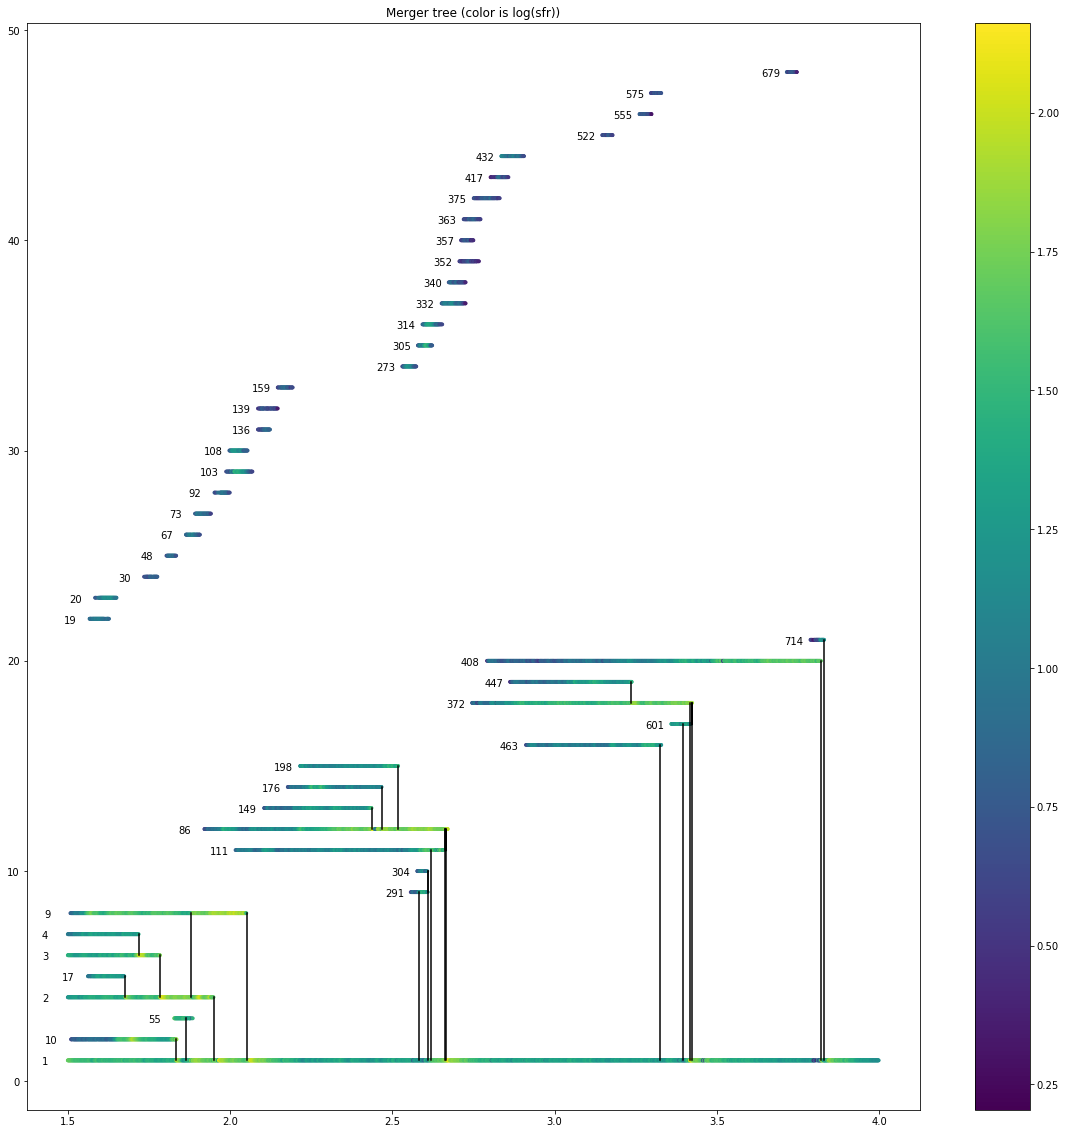

In [4]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=np.log10(txy['NSTARS']/5),s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is log(sfr))')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


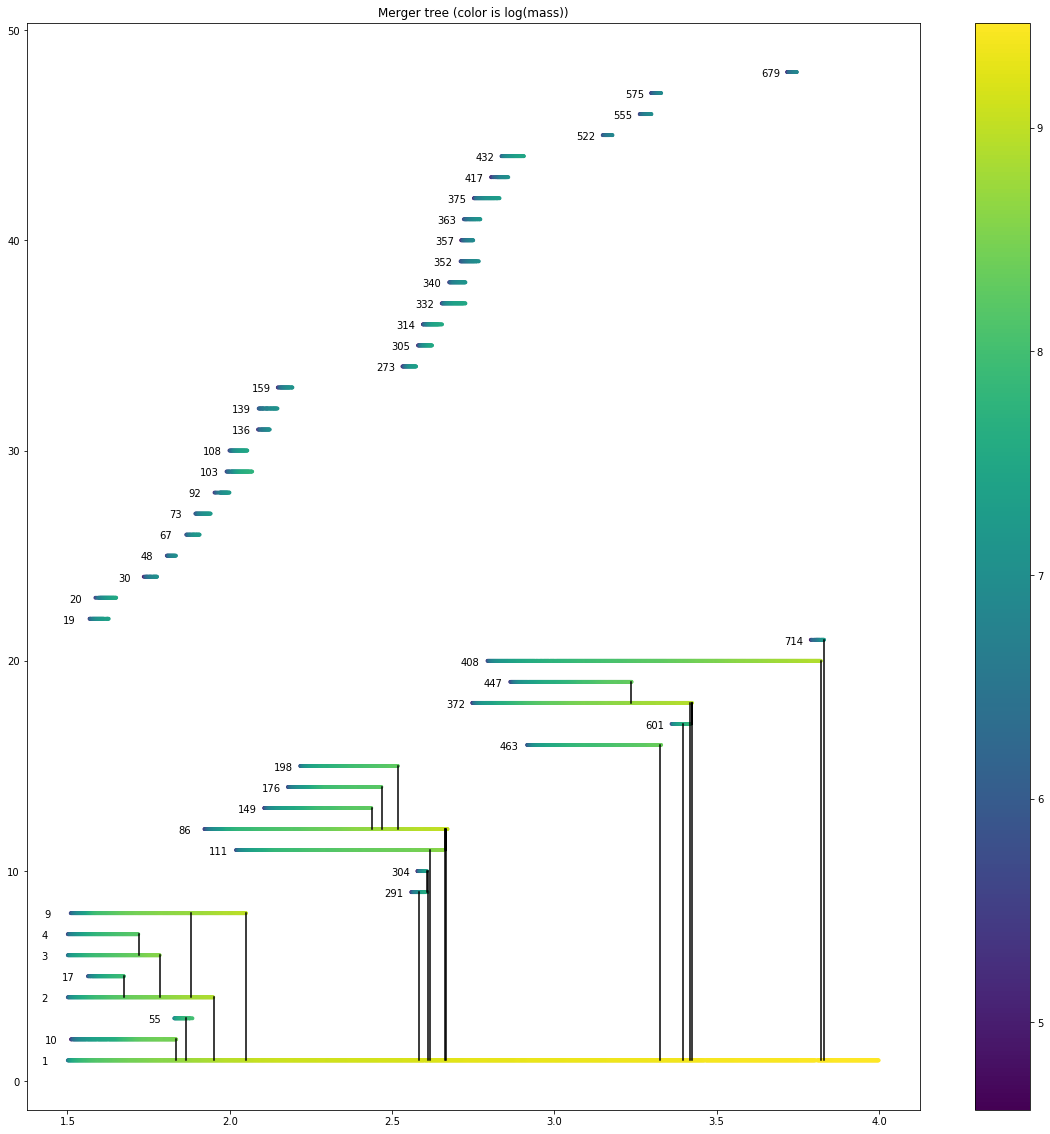

In [30]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=np.log10(txy['MASS']),s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is log(mass))')

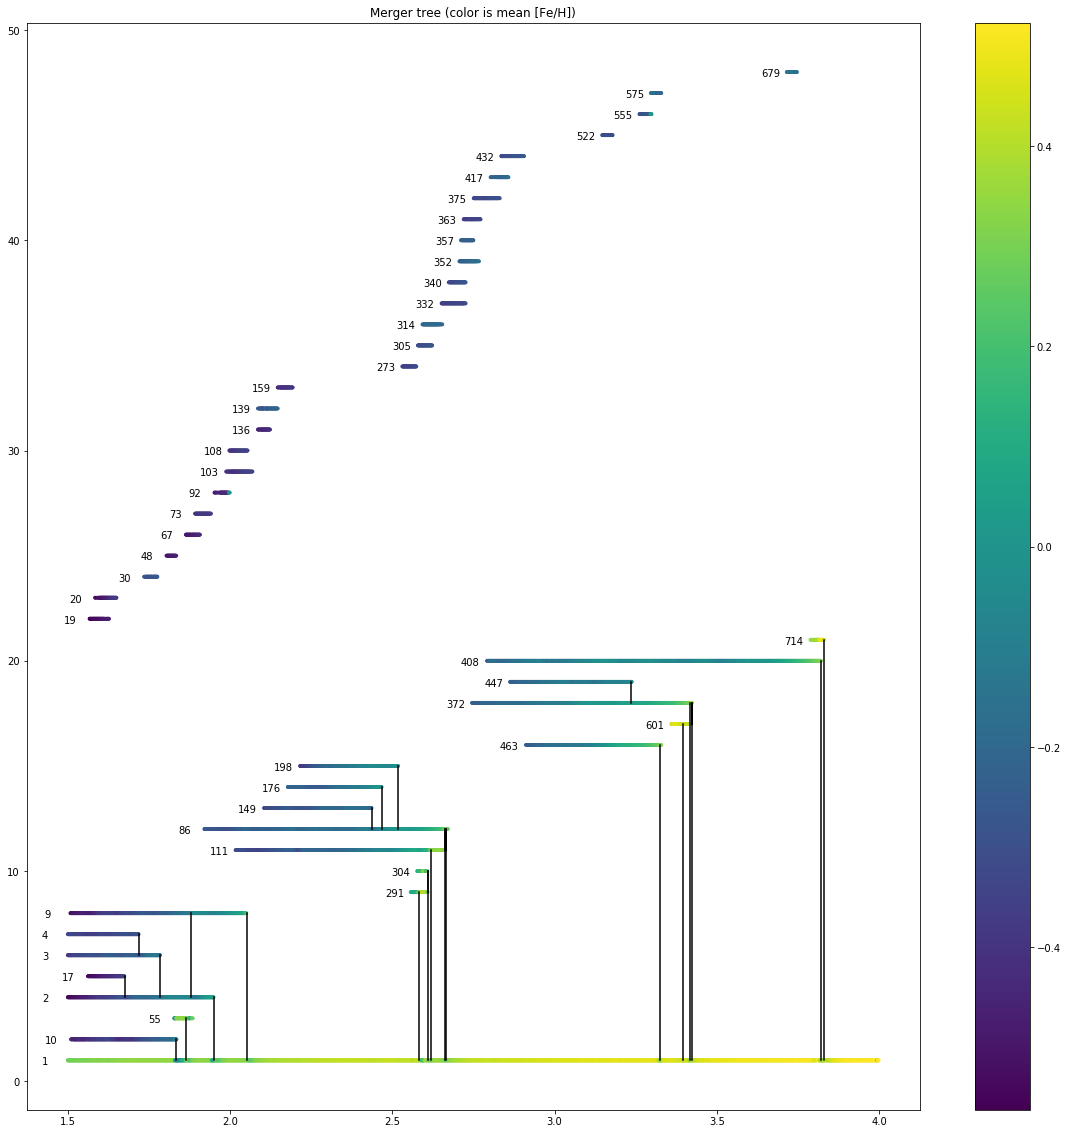

In [6]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=txy['MEANFEH'],s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is mean [Fe/H])')

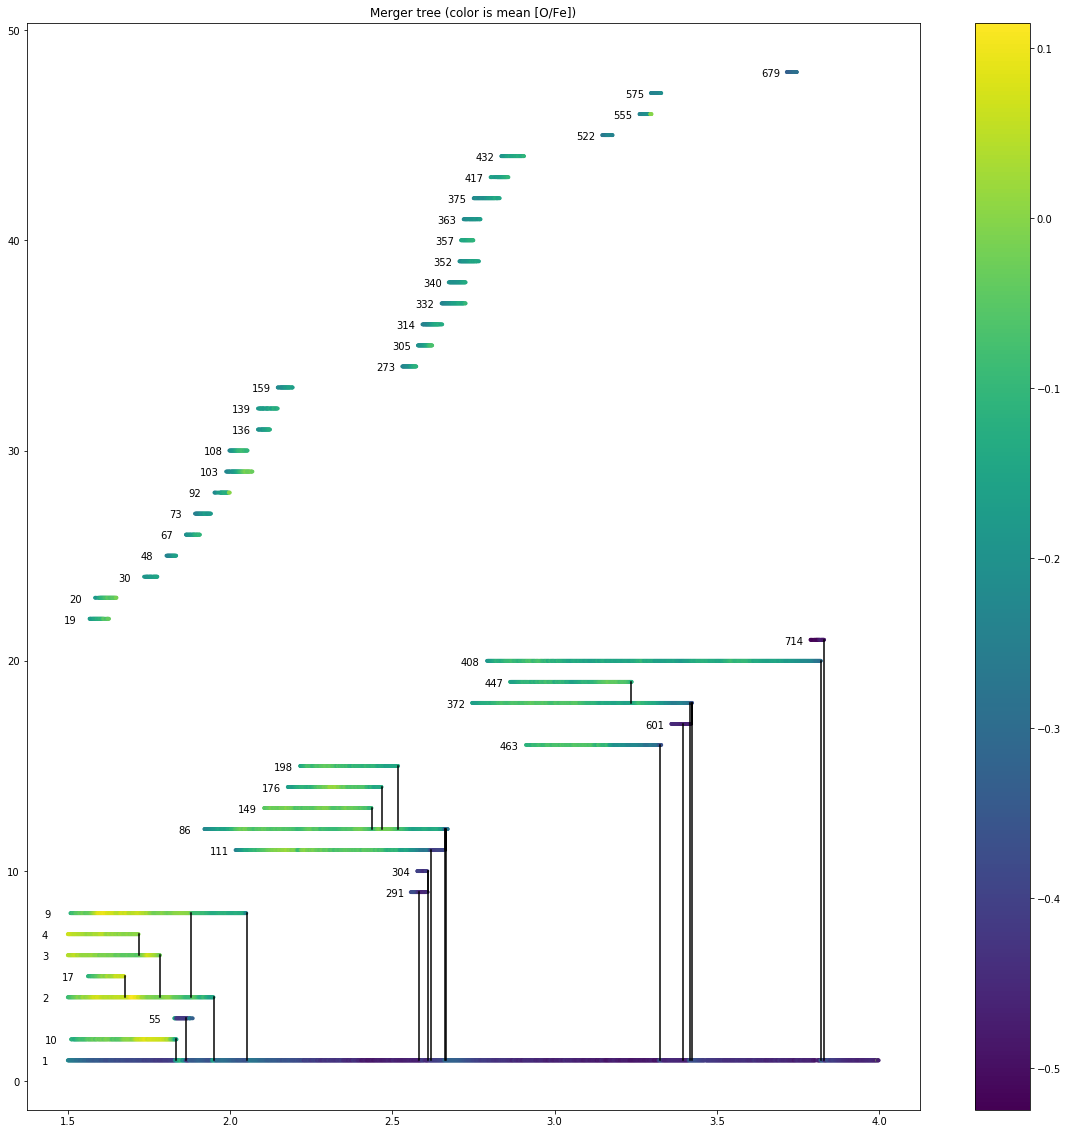

In [7]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=txy['MEANOFE'],s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is mean [O/Fe])')

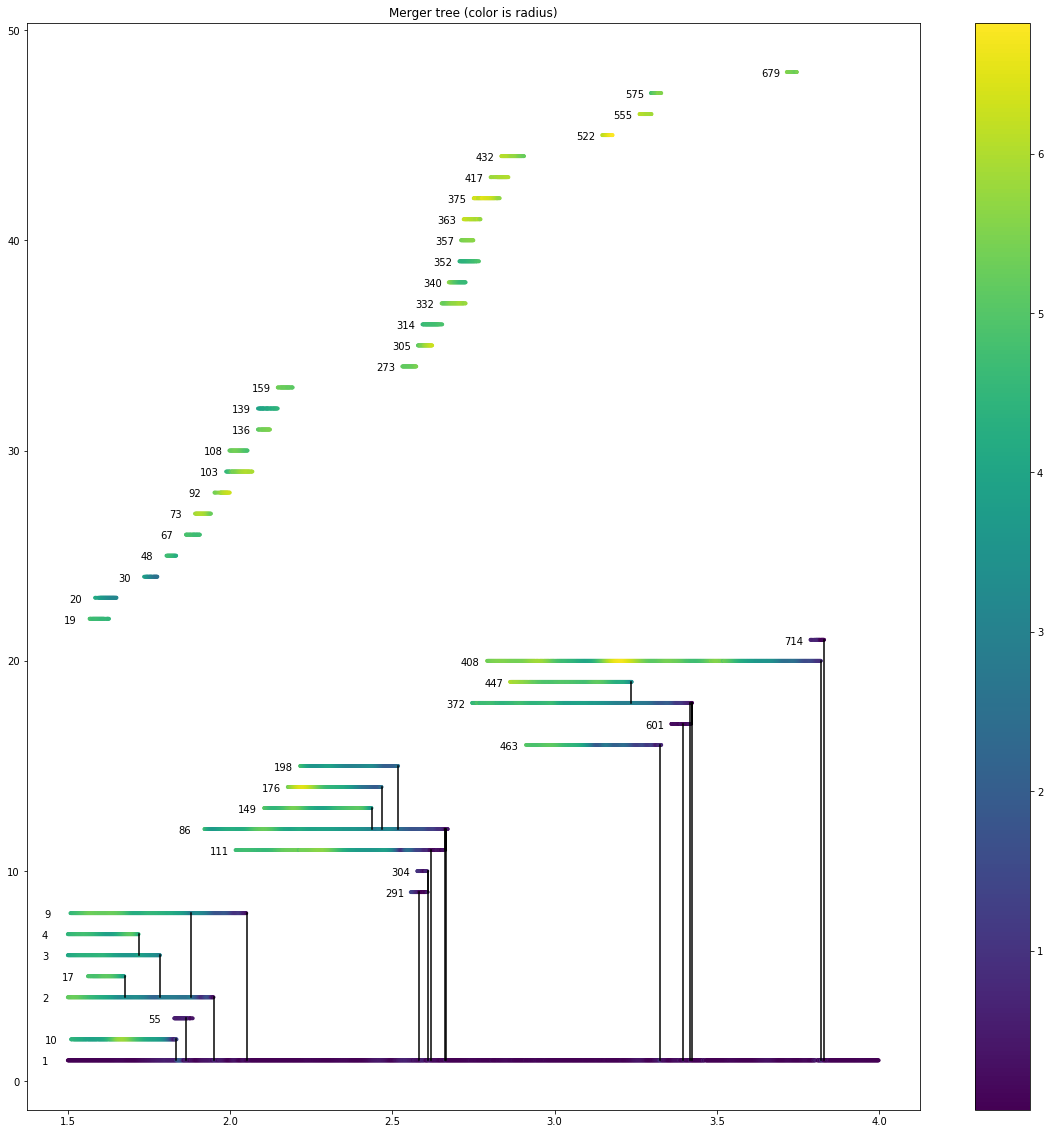

In [6]:
plt.figure(figsize=(20,20))
for i in idlist:
    clump = txy[(txy['ID']==i)]
    plt.text(clump['TIME'][0]-0.08,clump['ID'][0]-0.2,str(clump['CLUMPID'][0]))
plt.scatter(txy['TIME'],txy['ID'],c=(txy['X']**2+txy['Y']**2)**(1/2),s=8)
plt.colorbar()
for merge in merges:
    merge = list(merge)
    ids = merge[2:2+merge[1]]
    t = [merge[0]]*merge[1]
    plt.plot(t,ids,c='k')
    plt.title('Merger tree (color is radius)')

Text(0,0.5,'[O/Fe]')

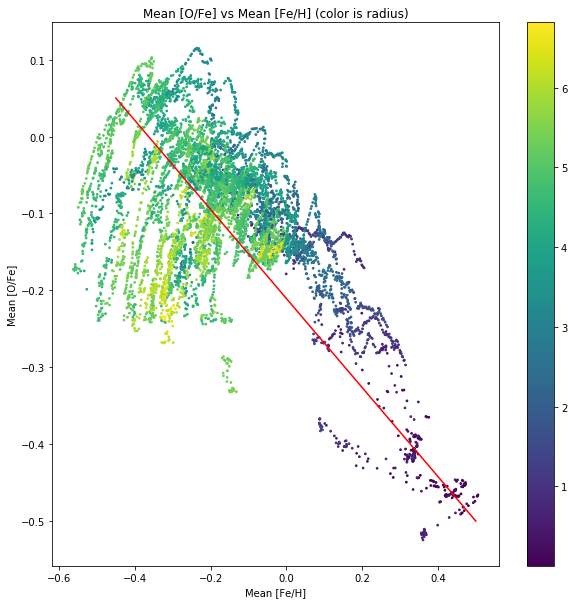

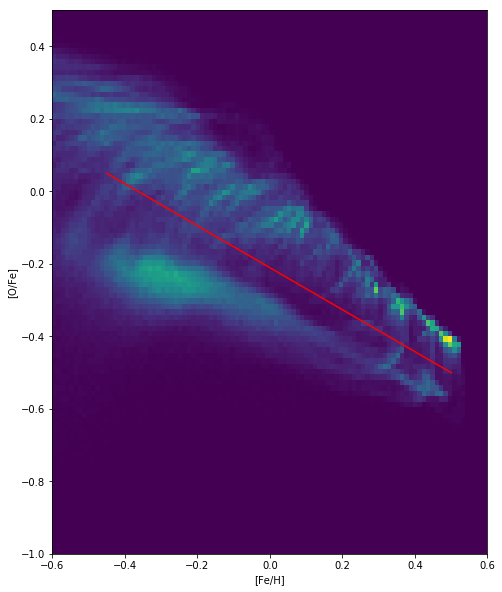

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(txy['MEANFEH'],txy['MEANOFE'],c=(txy['X']**2+txy['Y']**2)**(1/2),s=3)
plt.colorbar()
plt.xlabel('Mean [Fe/H]')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Mean [Fe/H] (color is radius)')
plt.plot([-0.45,0.5],[0.05,-0.5],color='r')

plt.figure(figsize=(10,10))
snapshot = FitsRead(40)
im, xedges, yedges  = np.histogram2d (snapshot['FEH'],snapshot['OFE'],(100,100),range=[[-0.6,0.6],[-1,0.5]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.plot([-0.45,0.5],[0.05,-0.5],color='r')
plt.imshow(im.T,extent=extent,origin='lower')
#plt.axes().set_aspect(1/2, 'datalim')
plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')

Text(0.5,0,'Mean SFR')

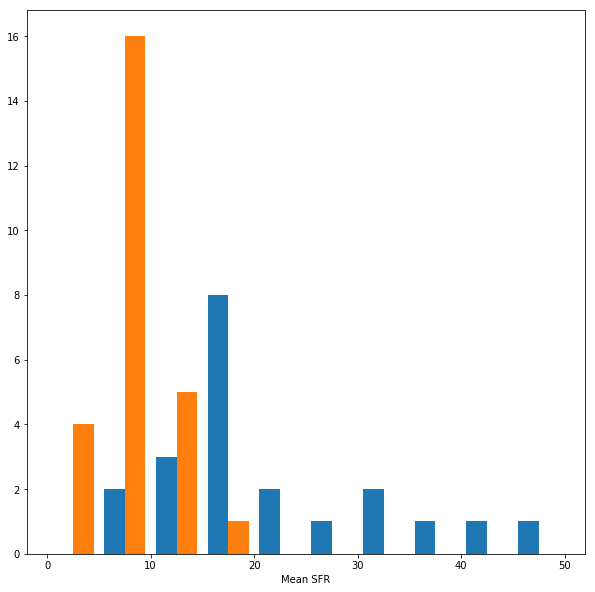

In [54]:
highAlpha = txy[(txy['MEANOFE']>alphaCutOff(txy['MEANFEH']))]
meansfrh = []
for i in np.unique(highAlpha['CLUMPID']):
    clump = txy[(txy['CLUMPID']==i)]
    meansfrh.append(np.mean(clump['NSTARS'])/5)
meansfrl = []
for i in np.unique(txy['CLUMPID']):
    lowAlpha = True
    for j in np.unique(highAlpha['CLUMPID']):
        if i==j:
            lowAlpha = False
            break
    if lowAlpha:
        clump = txy[(txy['CLUMPID']==i)]
        meansfrl.append(np.mean(clump['NSTARS'])/5)
bins1 = np.linspace(0,50,11)
plt.figure(figsize=(10,10))
plt.hist([meansfrh,meansfrl],bins1)
plt.xlabel('Mean SFR')

In [44]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, hold=None, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*. The return value is a
    tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
    [*patches0*, *patches1*,...]) if the input contains multiple
    data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or sequence of (n,) arrays
        Input values, this takes either a single array or a sequence of


(-4, 4)

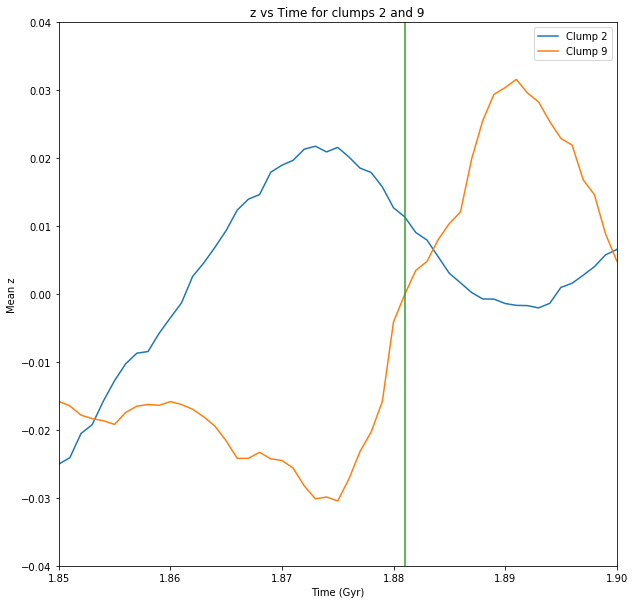

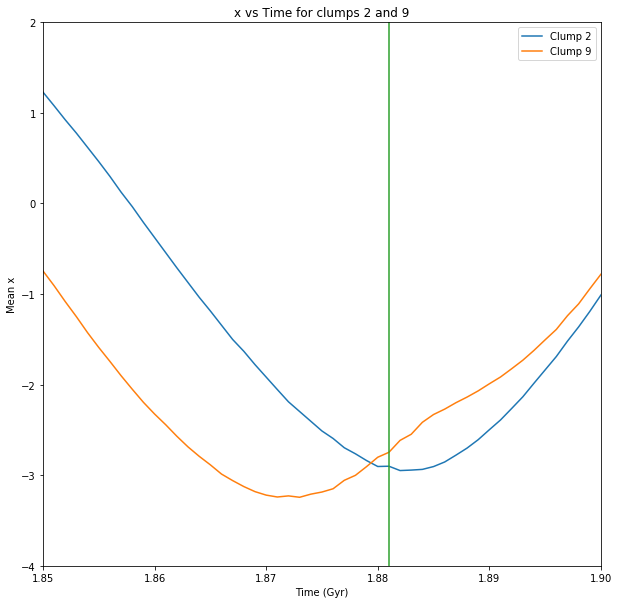

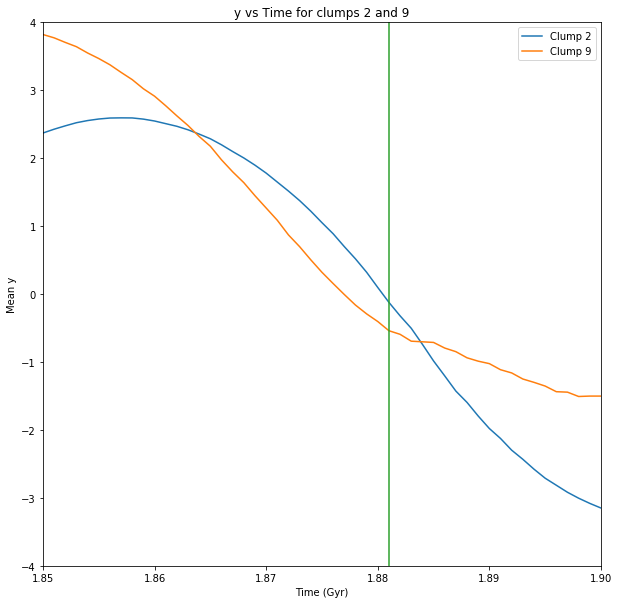

In [11]:
clump2 = txy[(txy['CLUMPID']==2)]
clump9 = txy[(txy['CLUMPID']==9)]
clump2a = clump2[(clump2['TIME']<1.8835)]
clump2b = clump9[(clump9['TIME']>1.8835)]
clump9a = clump9[(clump9['TIME']<1.8835)]
clump9b = clump2[(clump2['TIME']>1.8835)]
clump2 = vstack([clump2a,clump2b])
clump9 = vstack([clump9a,clump9b])
plt.figure(figsize=(10,10))
clumps = vstack([clump2,clump9])
#plt.scatter(clumps['TIME'],clumps['Z'],c=(clumps['X']**2+clumps['Y']**2)**(1/2),s=3)
plt.plot(clump2['TIME'],clump2['Z'],label='Clump 2')
plt.plot(clump9['TIME'],clump9['Z'],label='Clump 9')
plt.legend()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean z')
plt.title('z vs Time for clumps 2 and 9')
#plt.colorbar()
merges2 = Table.read('clumps5.fits',3)
merge2 = merges2[(merges2['CLUMP1']==2)]
merge29 = merge2[(merge2['CLUMP2']==9)]
plt.plot([merge29['TIME'][0],merge29['TIME'][0]],[-0.1,0.05])
plt.xlim(1.85,1.9)
plt.ylim(-0.04,0.04)

plt.figure(figsize=(10,10))
plt.plot(clump2['TIME'],clump2['X'],label='Clump 2')
plt.plot(clump9['TIME'],clump9['X'],label='Clump 9')
plt.legend()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean x')
plt.title('x vs Time for clumps 2 and 9')
plt.plot([merge29['TIME'][0],merge29['TIME'][0]],[-4,4])
plt.xlim(1.85,1.9)
plt.ylim(-4,2)

plt.figure(figsize=(10,10))
plt.plot(clump2['TIME'],clump2['Y'],label='Clump 2')
plt.plot(clump9['TIME'],clump9['Y'],label='Clump 9')
plt.legend()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean y')
plt.title('y vs Time for clumps 2 and 9')
plt.plot([merge29['TIME'][0],merge29['TIME'][0]],[-4,4])
plt.xlim(1.85,1.9)
plt.ylim(-4,4)

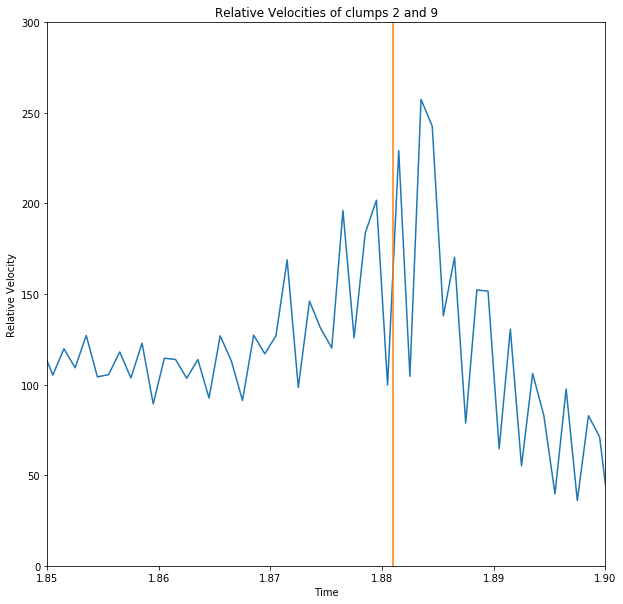

In [42]:
vx2 = []
vy2 = []
vz2 = []
t2 = []
vx9 = []
vy9 = []
vz9 = []
t9 = []

for i in range(1,len(clump2)):
    dt = clump2['TIME'][i]-clump2['TIME'][i-1]
    t2.append(clump2['TIME'][i]-dt/2)
    vx2.append((clump2['X'][i]-clump2['X'][i-1])/dt)
    vy2.append((clump2['Y'][i]-clump2['Y'][i-1])/dt)
    vz2.append((clump2['Z'][i]-clump2['Z'][i-1])/dt)
for i in range(1,len(clump9)):
    dt = clump9['TIME'][i]-clump9['TIME'][i-1]
    t9.append(clump9['TIME'][i]-dt/2)
    vx9.append((clump9['X'][i]-clump9['X'][i-1])/dt)
    vy9.append((clump9['Y'][i]-clump9['Y'][i-1])/dt)
    vz9.append((clump9['Z'][i]-clump9['Z'][i-1])/dt)
Vx2 = UnivariateSpline(t2,vx2)
Vy2 = UnivariateSpline(t2,vy2)
Vz2 = UnivariateSpline(t2,vz2)
Vx9 = UnivariateSpline(t9,vx9)
Vy9 = UnivariateSpline(t9,vy9)
Vz9 = UnivariateSpline(t9,vz9)

t = t2
vdiff = ((Vx2(t)-Vx9(t))**2+(Vy2(t)-Vy9(t))**2+(Vz2(t)-Vz9(t))**2)**(1/2)
fig = plt.figure(figsize=(10,10))
plt.plot(t,vdiff)
plt.plot([merge29['TIME'][0],merge29['TIME'][0]],[-0,300])
plt.ylim(0,300)
plt.xlim(1.85,1.9)
plt.xlabel('Time')
plt.ylabel('Relative Velocity')
plt.title('Relative Velocities of clumps 2 and 9')
fig.savefig('relative_velocities.pdf')

Text(0.5,1,'Mean [Fe/H] vs Time (color is radius)')

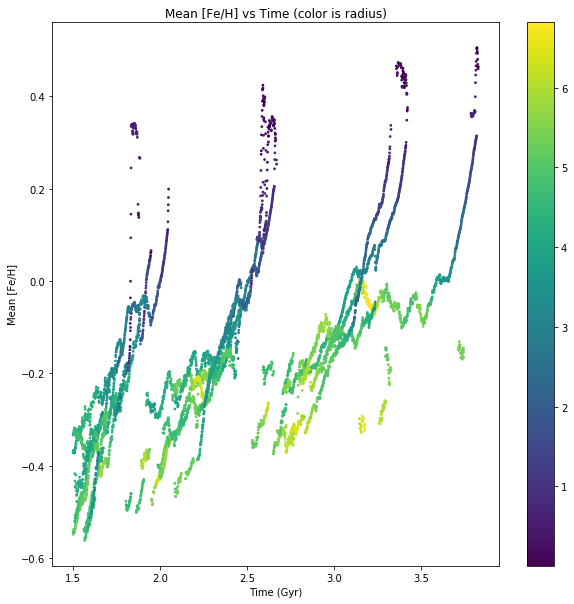

In [19]:
txy2 = txy
txy = txy2[(txy2['CLUMPID']!=1)]
plt.figure(figsize=(10,10))
plt.scatter(txy['TIME'],txy['MEANFEH'],c=(txy['X']**2+txy['Y']**2)**(1/2),s=3)
plt.colorbar()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs Time (color is radius)')

Text(0.5,1,'Mean [O/Fe] vs Time (color is radius)')

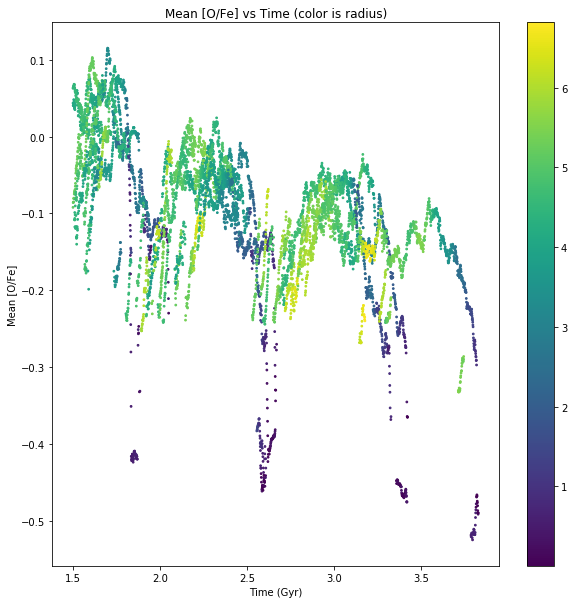

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(txy['TIME'],txy['MEANOFE'],c=(txy['X']**2+txy['Y']**2)**(1/2),s=3)
plt.colorbar()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Time (color is radius)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [Fe/H] vs Time (color is log(mass))')

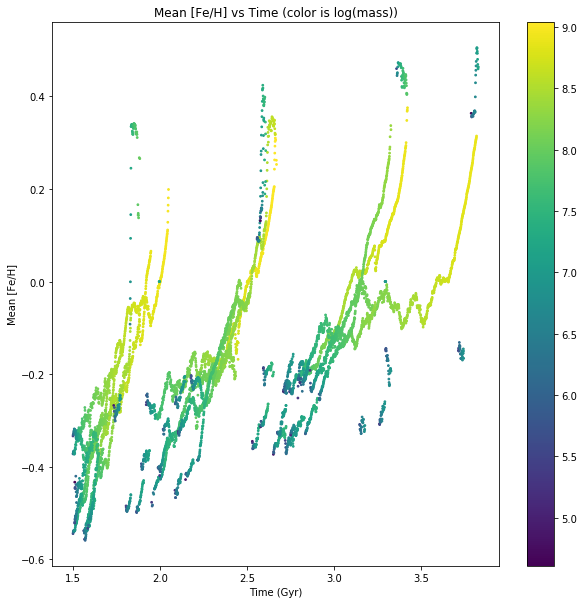

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(txy['TIME'],txy['MEANFEH'],c=np.log10(txy['MASS']),s=3)
plt.colorbar()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs Time (color is log(mass))')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [O/Fe] vs Time (color is log(mass))')

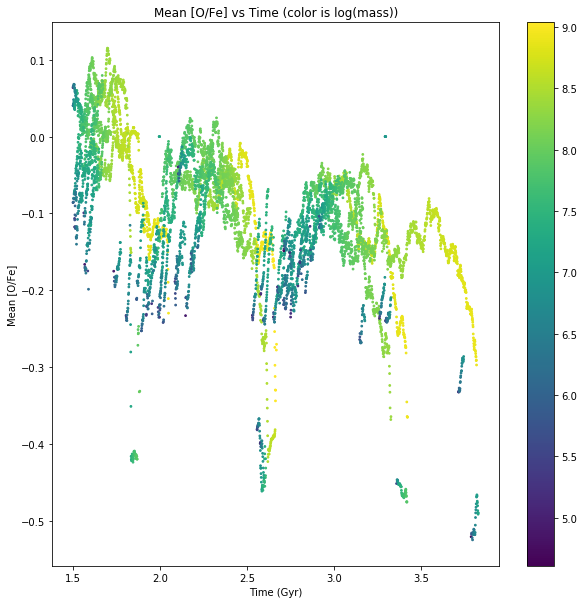

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(txy['TIME'],txy['MEANOFE'],c=np.log10(txy['MASS']),s=3)
plt.colorbar()
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Time (color is log(mass))')

Text(0.5,1,'Mean [Fe/H] vs Radius (color is time)')

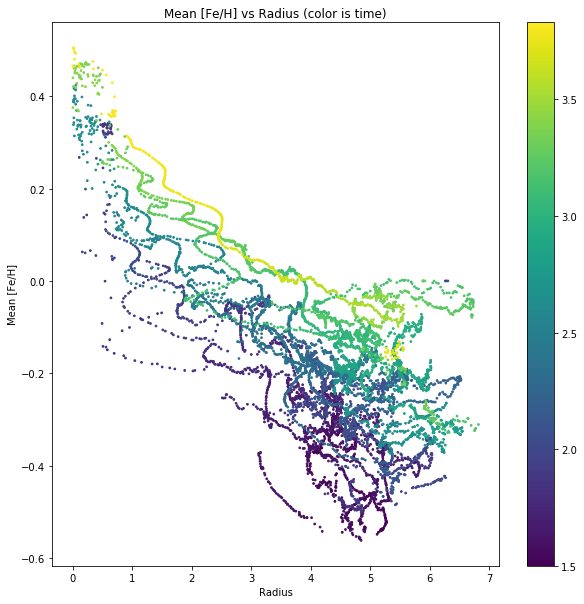

In [12]:
plt.figure(figsize=(10,10))
plt.scatter((txy['X']**2+txy['Y']**2)**(1/2),txy['MEANFEH'],c=txy['TIME'],s=3)
plt.colorbar()
plt.xlabel('Radius')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs Radius (color is time)')

Text(0.5,1,'Mean [O/Fe] vs Radius (color is time)')

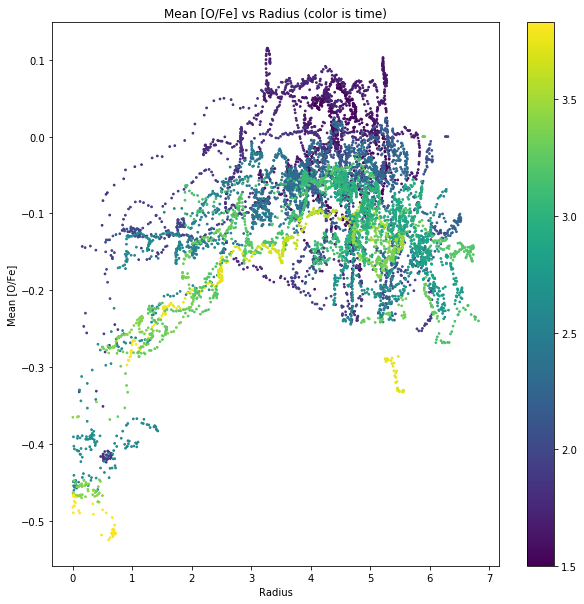

In [13]:
plt.figure(figsize=(10,10))
plt.scatter((txy['X']**2+txy['Y']**2)**(1/2),txy['MEANOFE'],c=txy['TIME'],s=3)
plt.colorbar()
plt.xlabel('Radius')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Radius (color is time)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [O/Fe] vs Mean [Fe/H] (color is log clump age)')

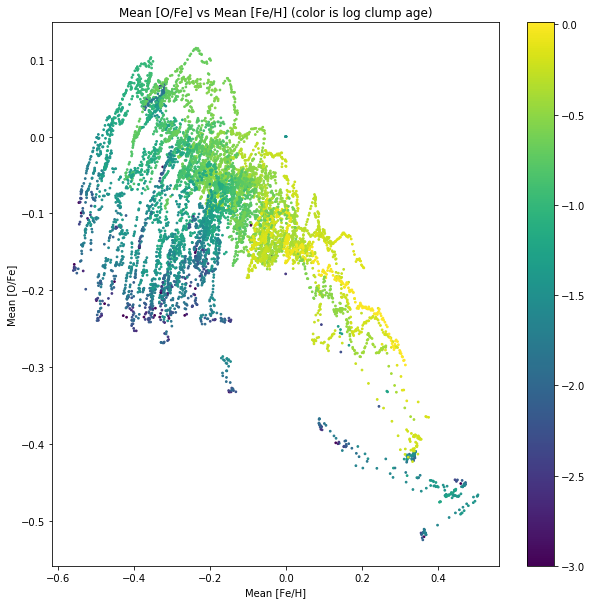

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(txy['MEANFEH'],txy['MEANOFE'],c=np.log10(txy['AGE']),s=3)
plt.colorbar()
plt.xlabel('Mean [Fe/H]')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Mean [Fe/H] (color is log clump age)')

Text(0.5,1,'Mean [O/Fe] vs Time')

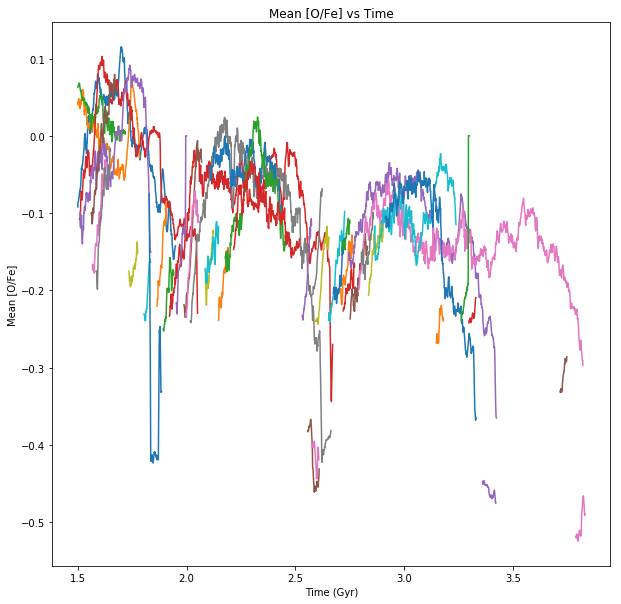

In [16]:
plt.figure(figsize=(10,10))
for clumpid in np.unique(np.array(txy['CLUMPID'])):
    txyclump = txy[(txy['CLUMPID']==clumpid)]
    plt.plot(txyclump['TIME'],txyclump['MEANOFE'])
plt.xlabel('Time (Gyr)')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Time')

C:\Users\betha\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


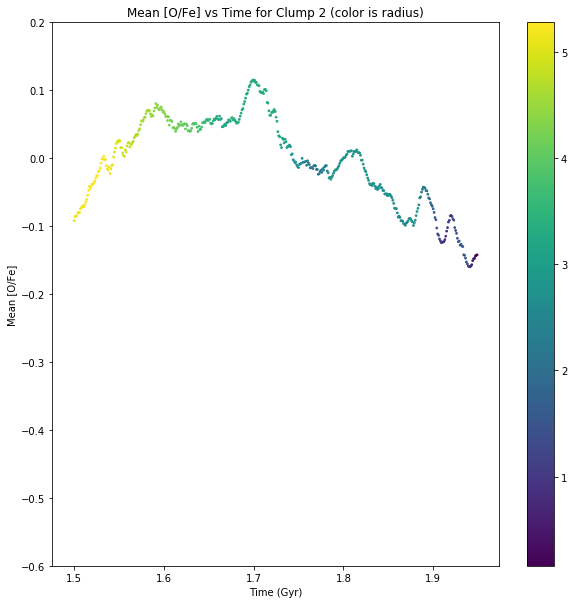

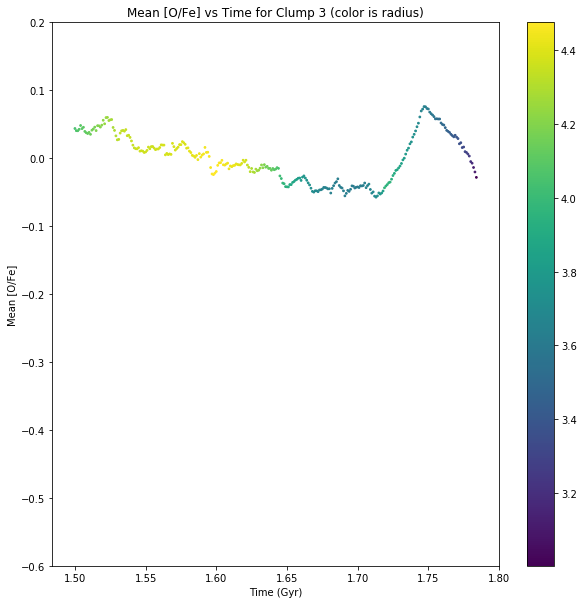

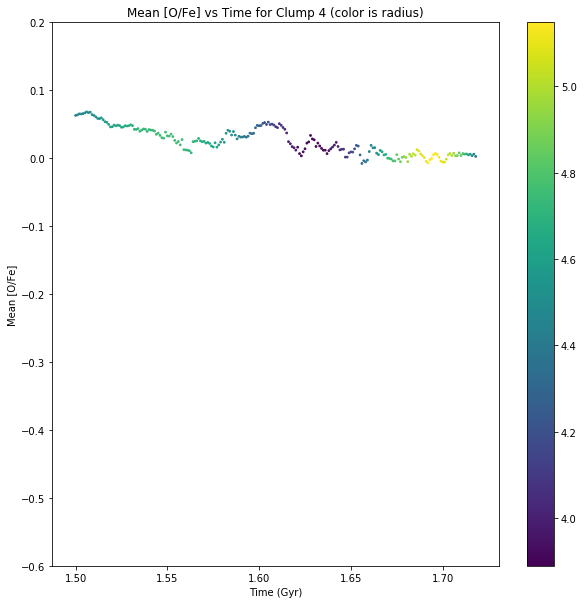

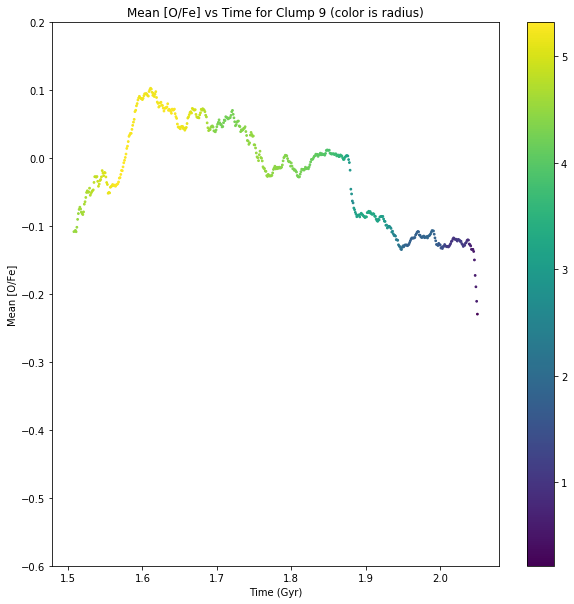

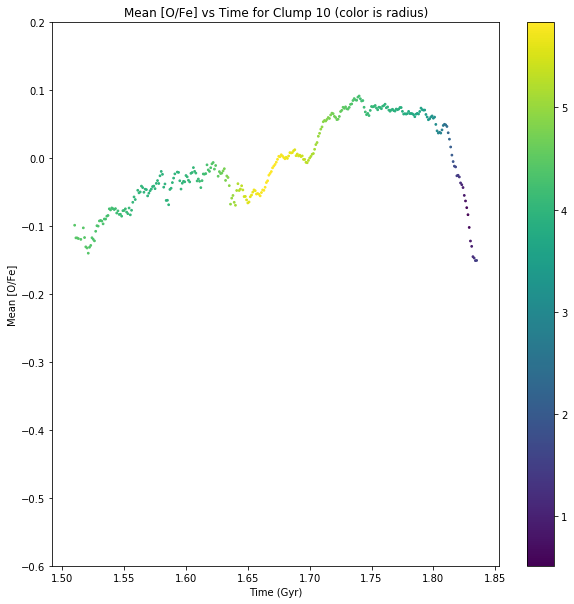

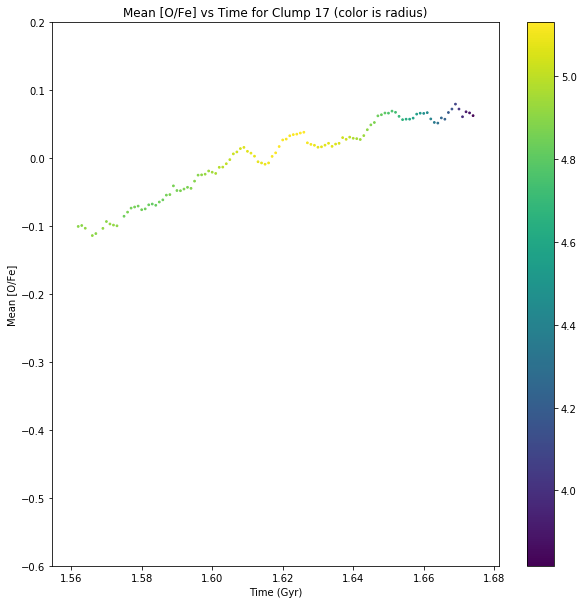

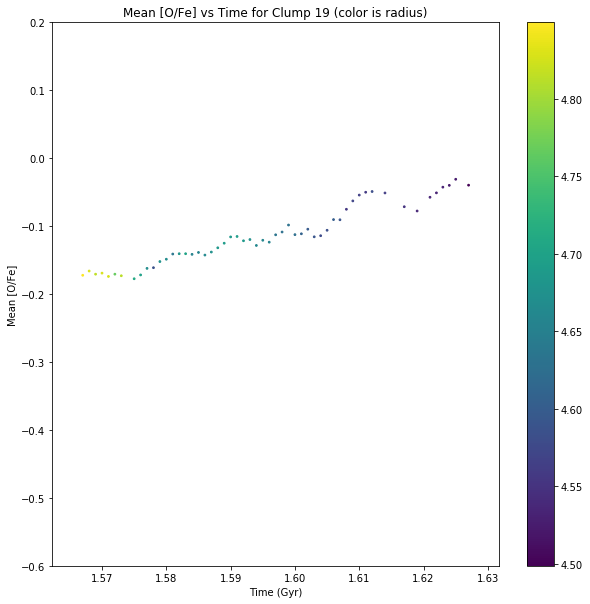

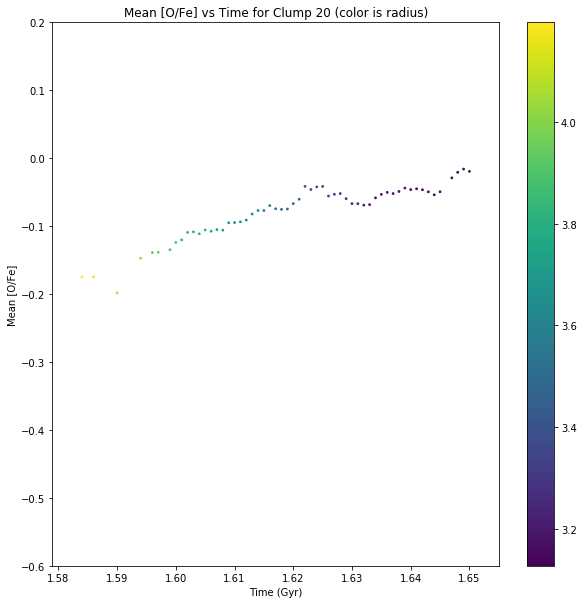

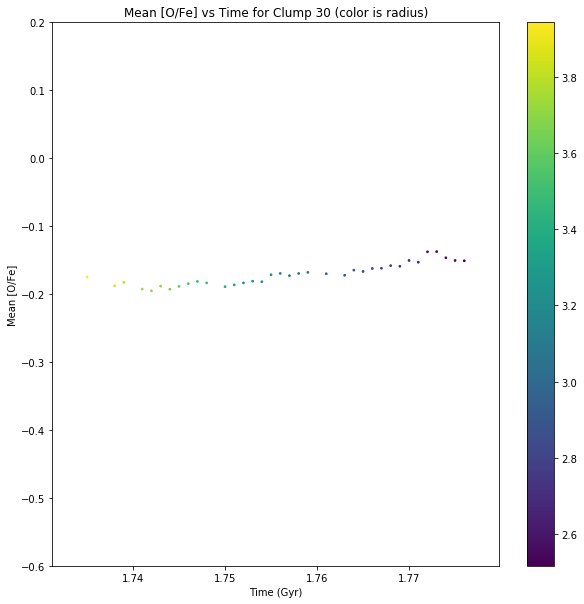

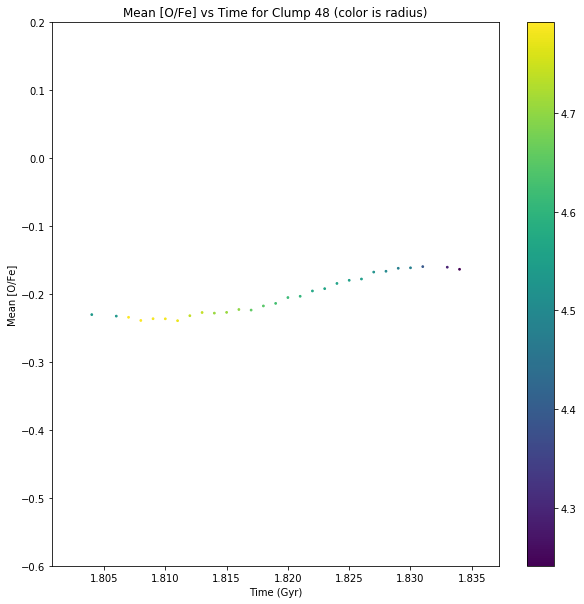

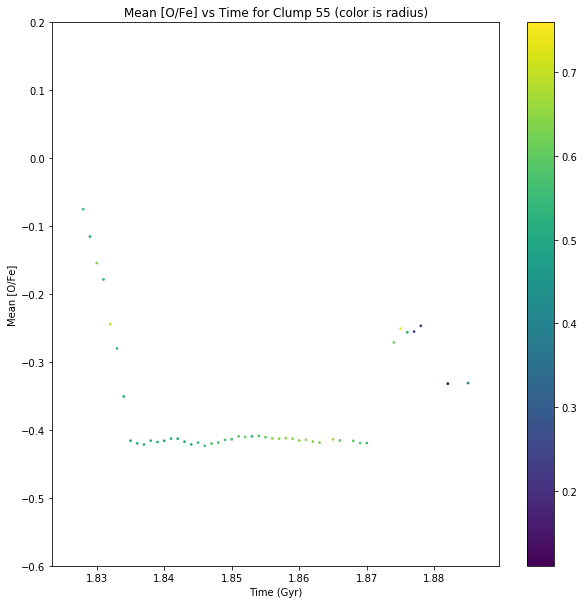

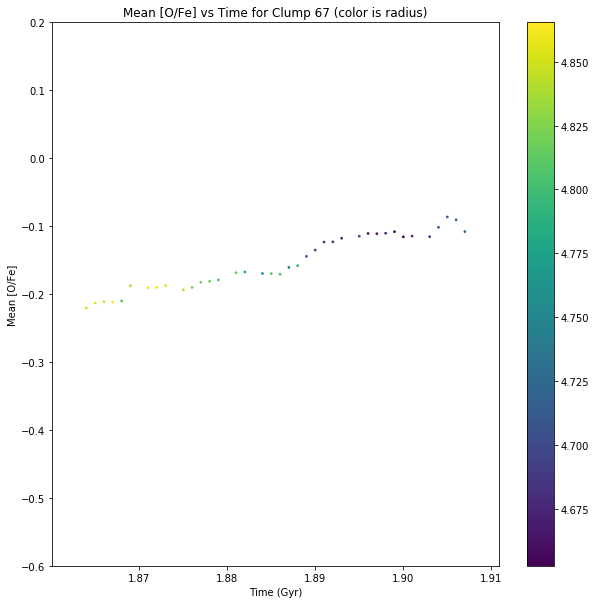

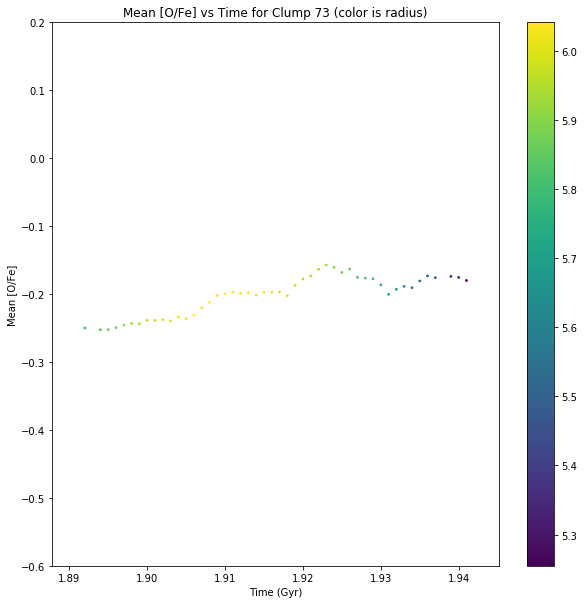

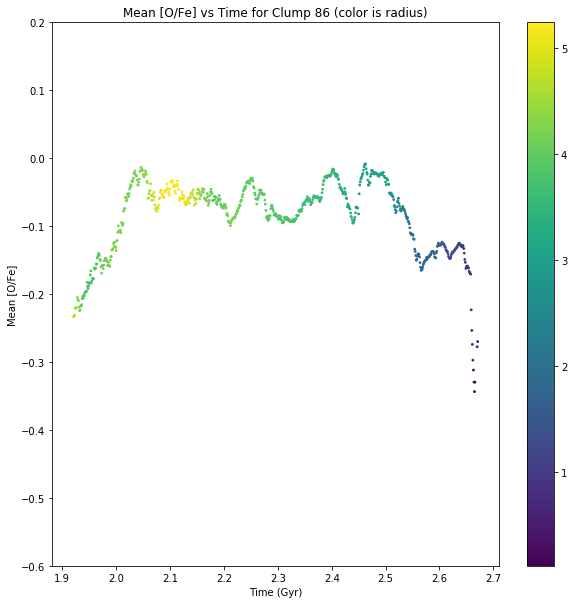

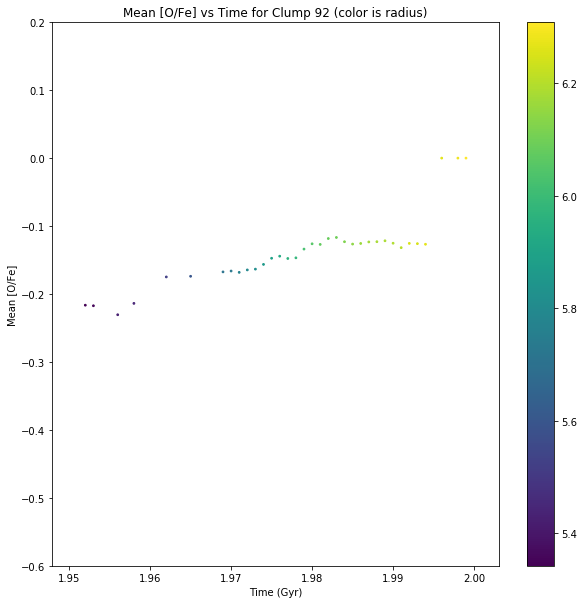

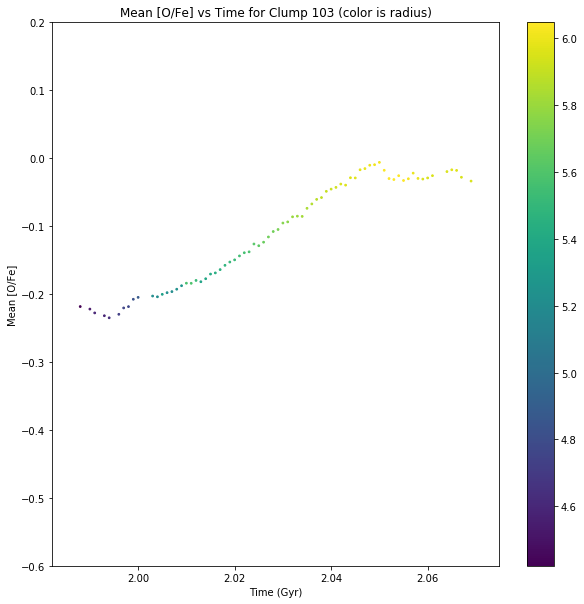

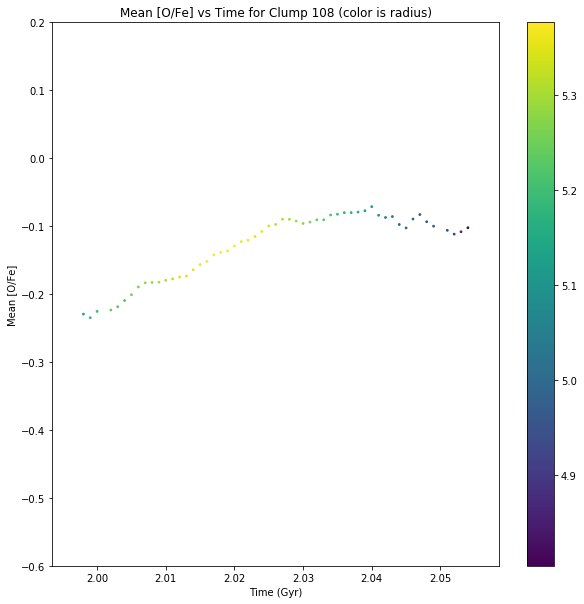

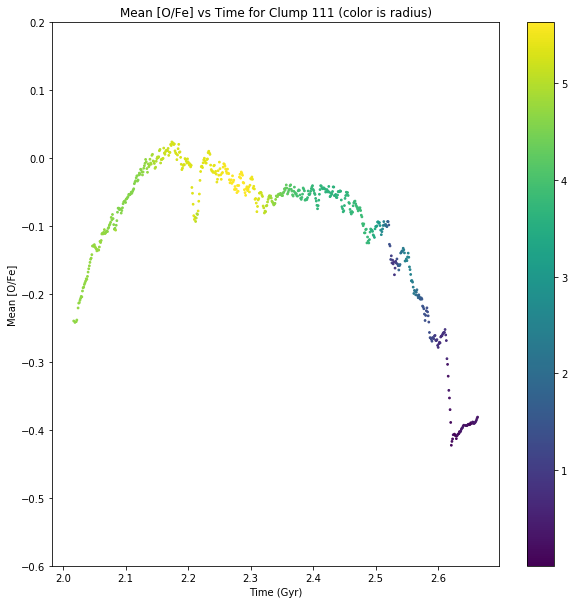

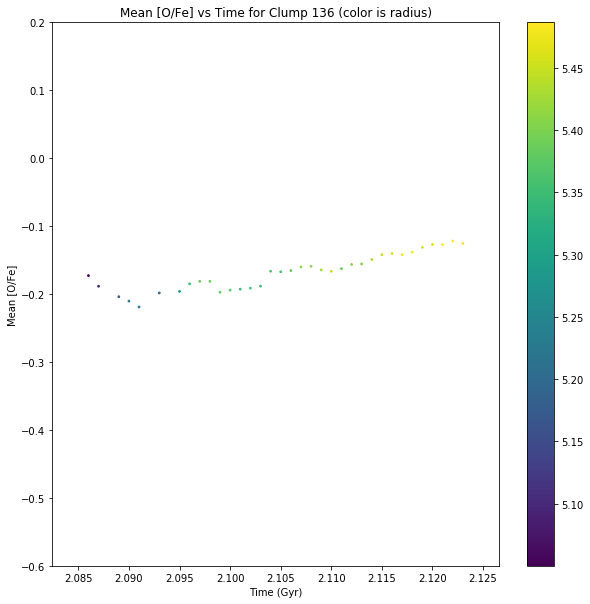

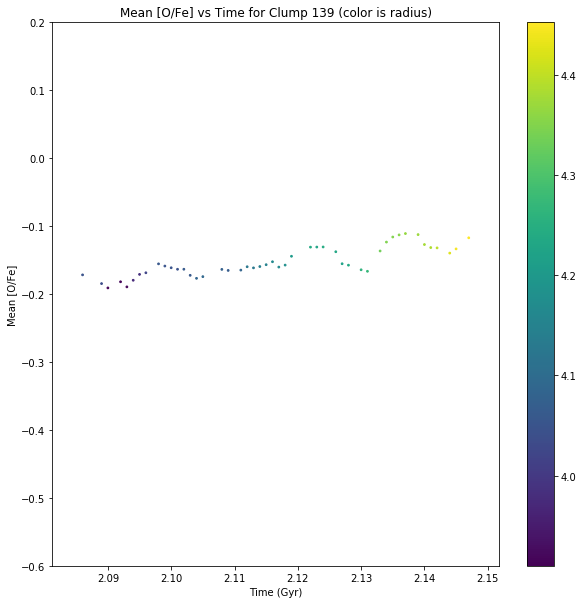

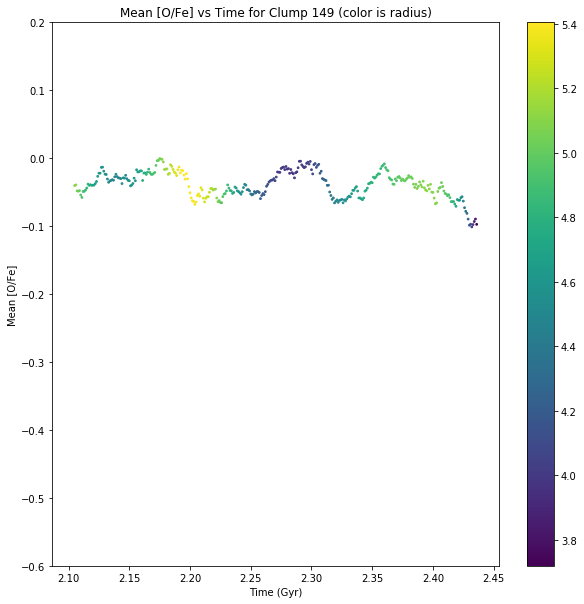

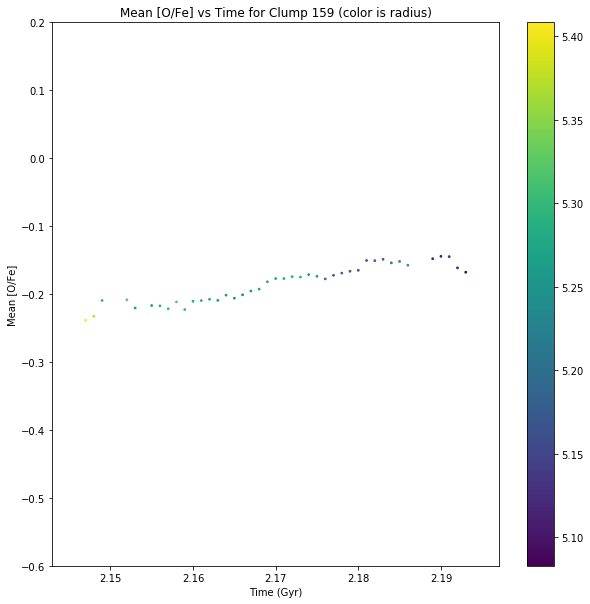

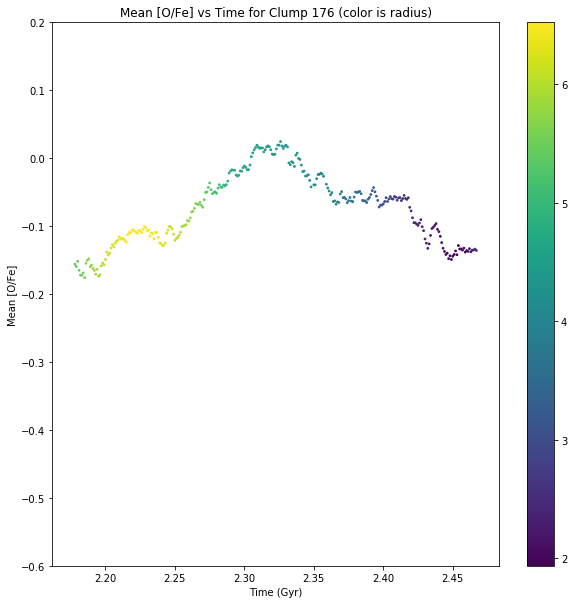

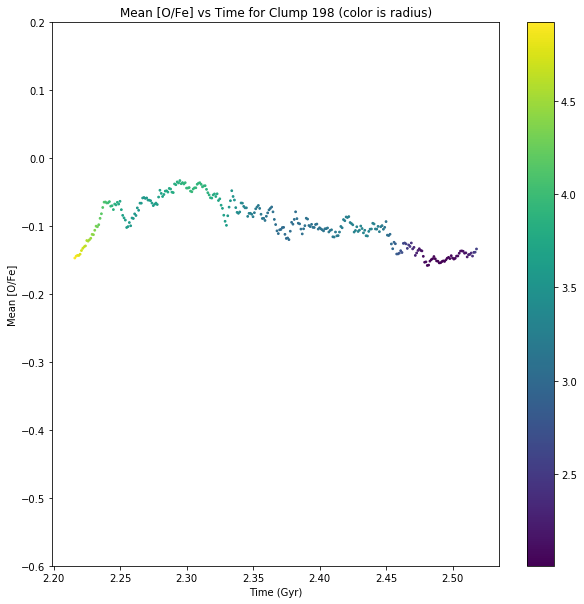

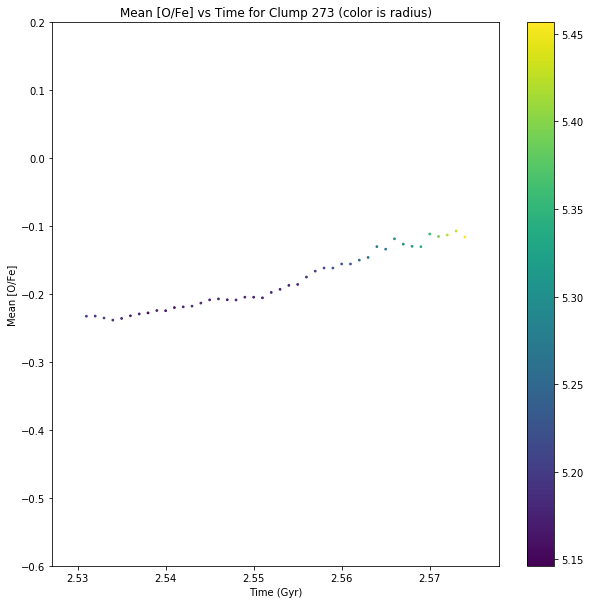

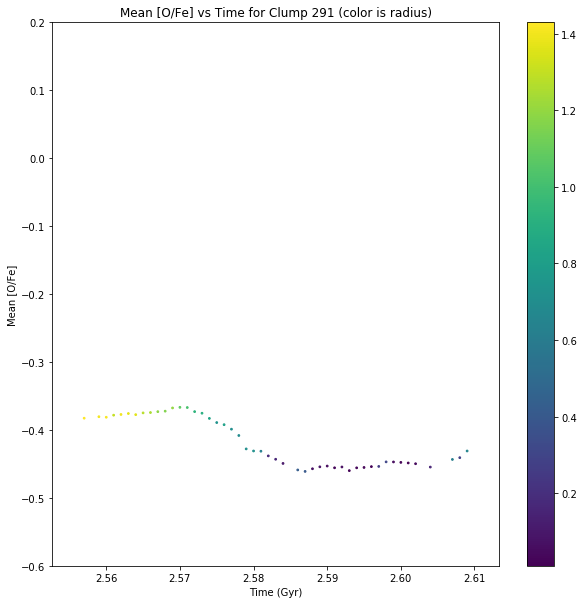

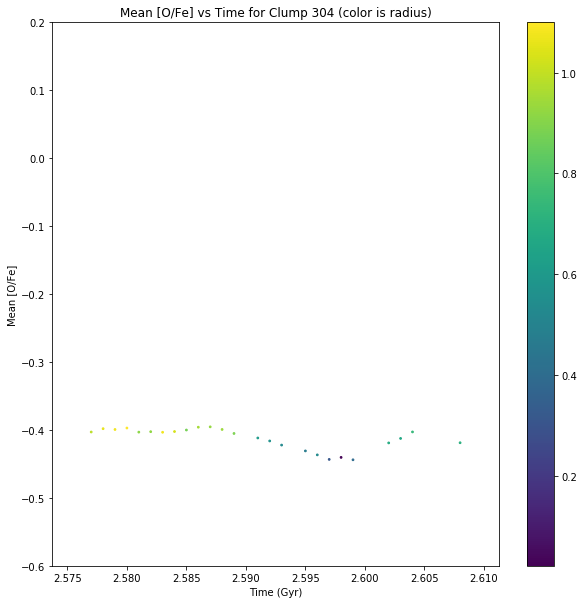

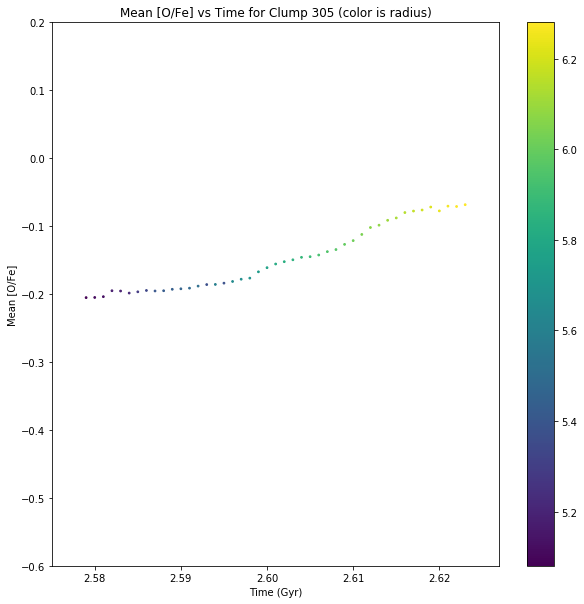

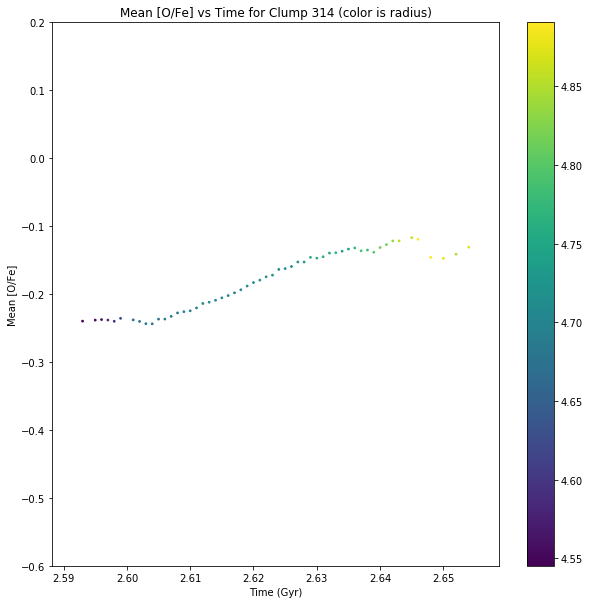

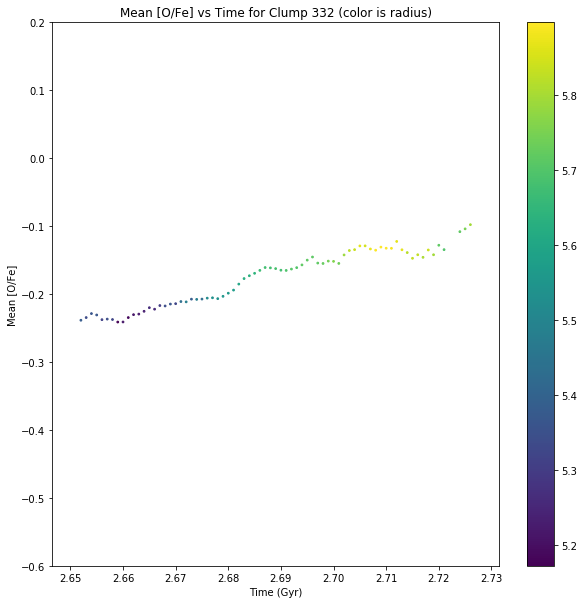

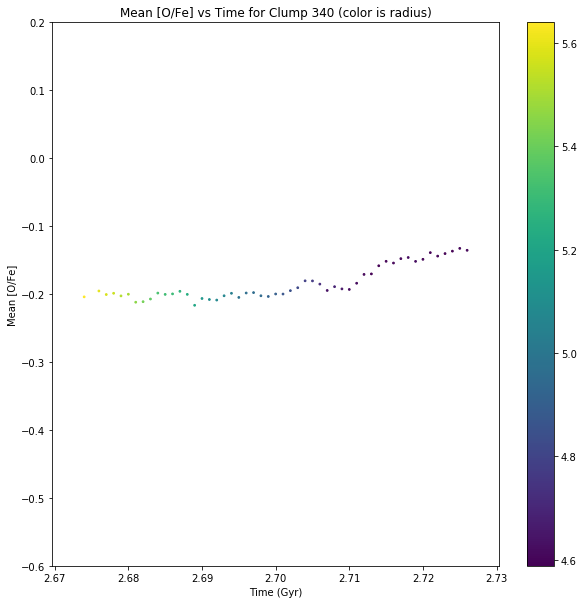

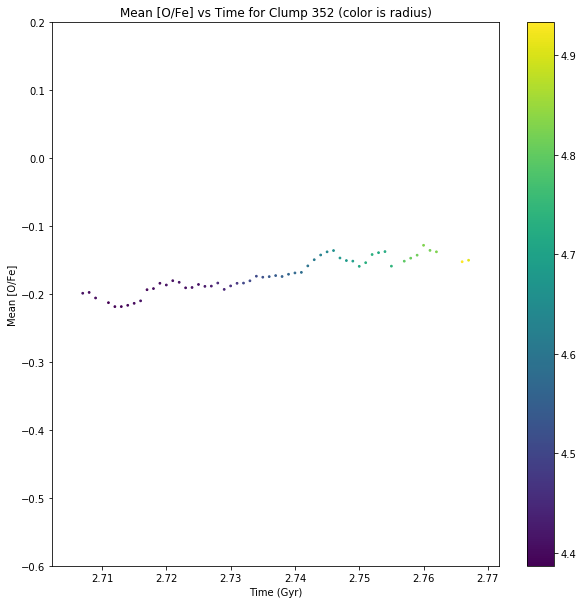

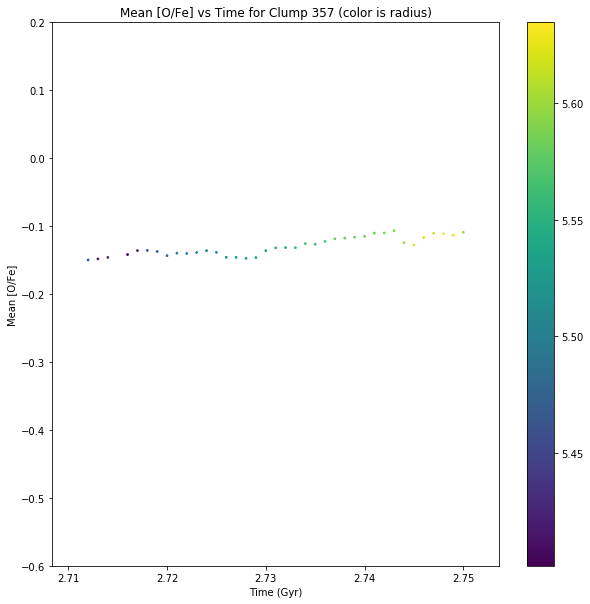

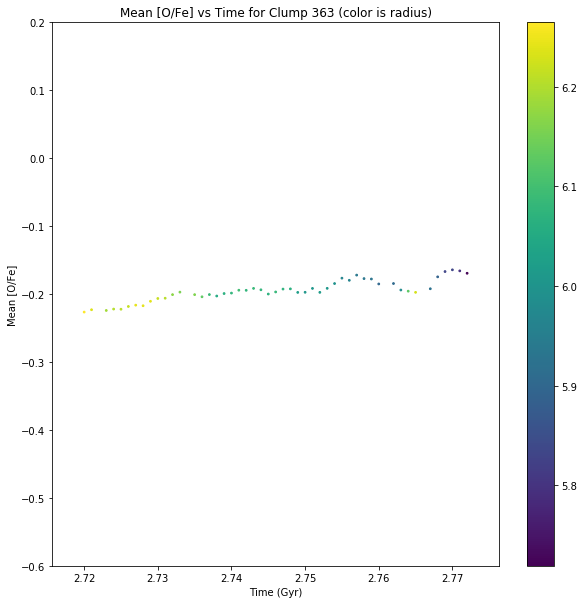

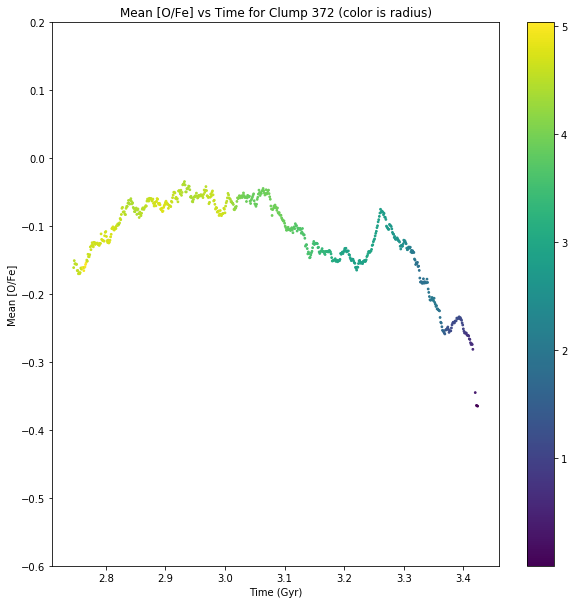

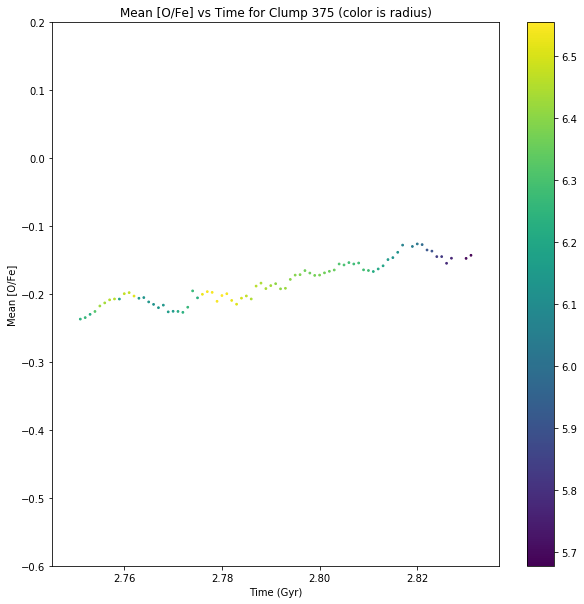

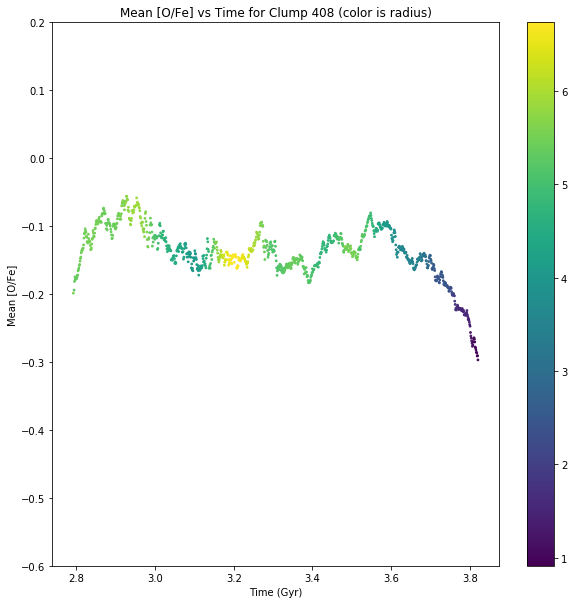

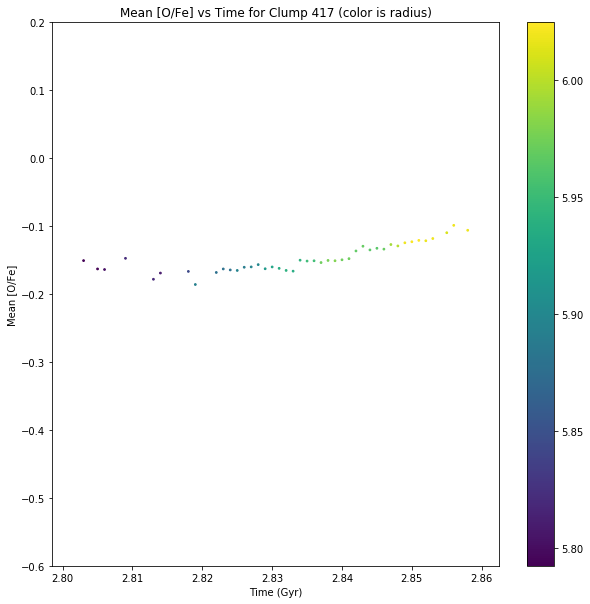

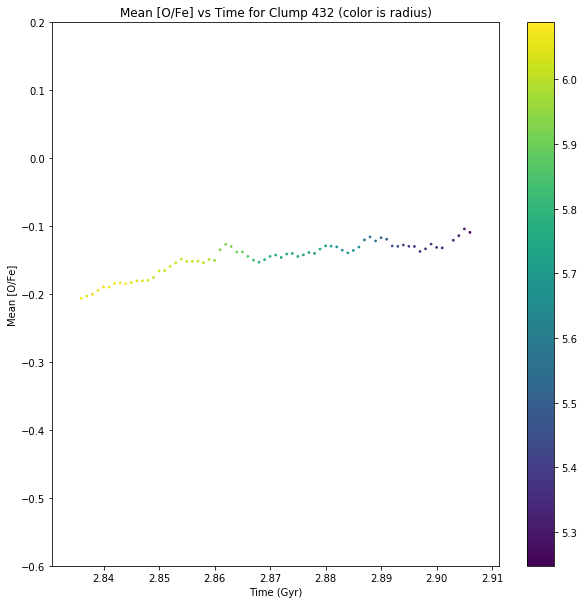

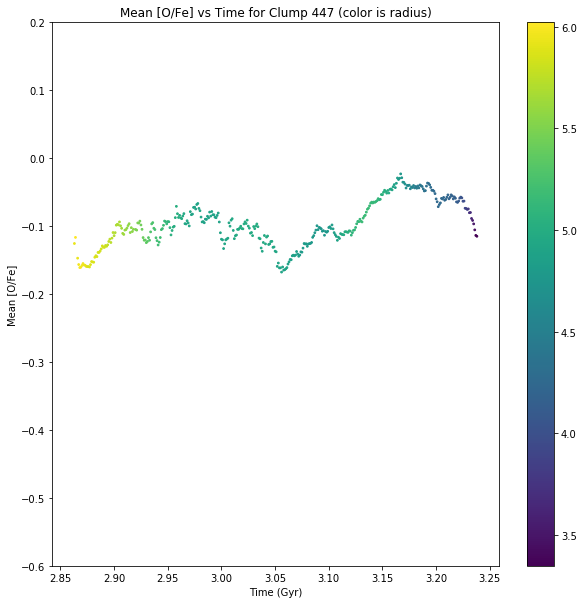

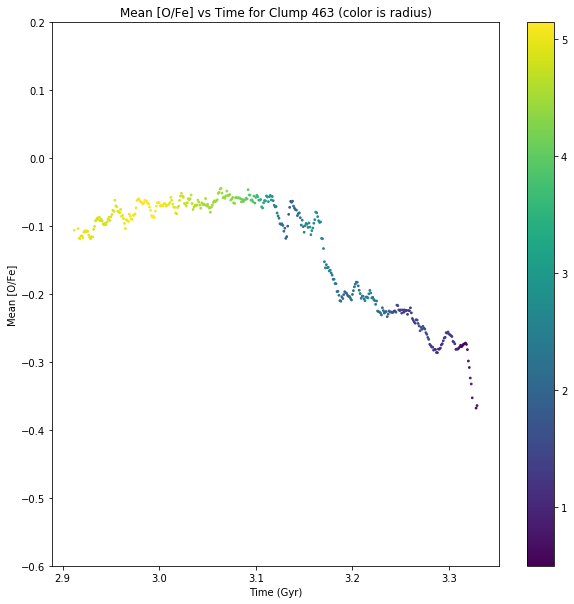

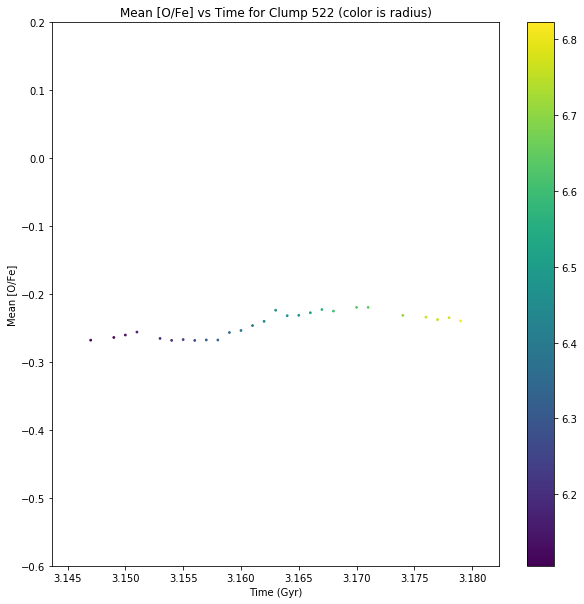

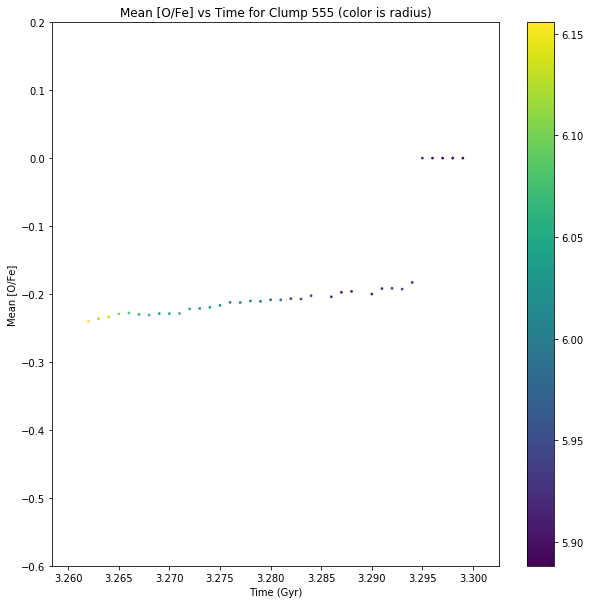

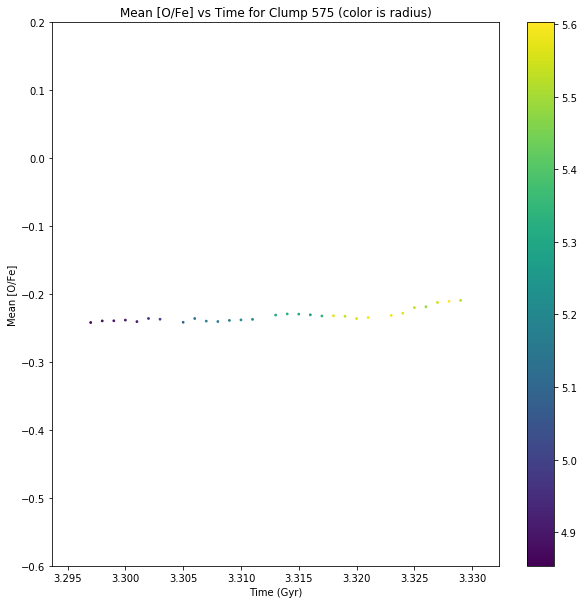

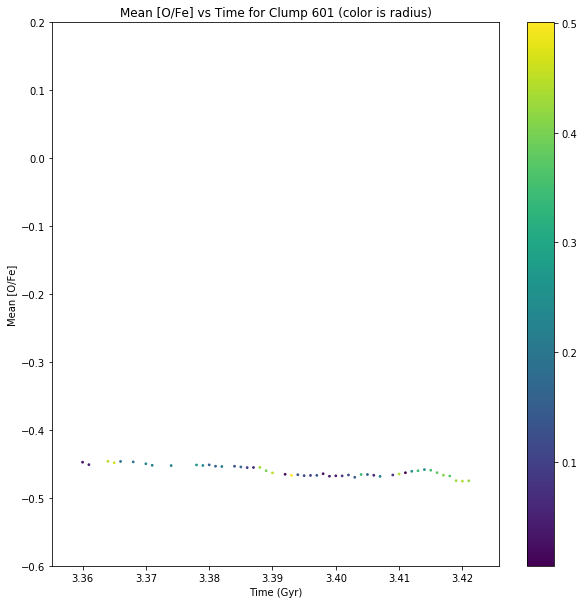

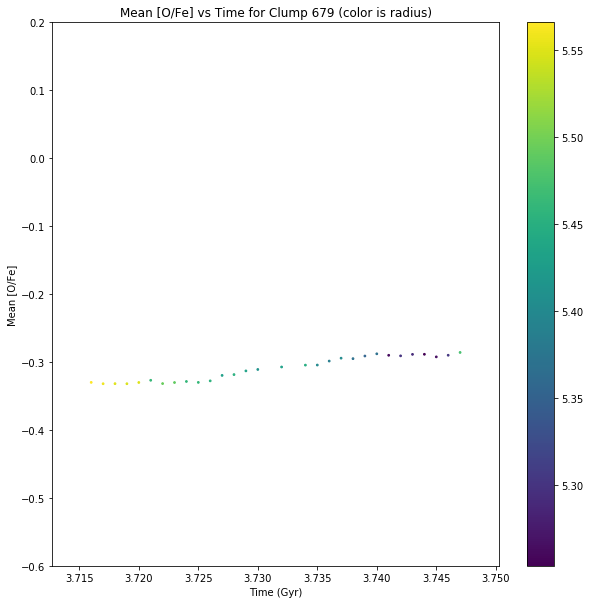

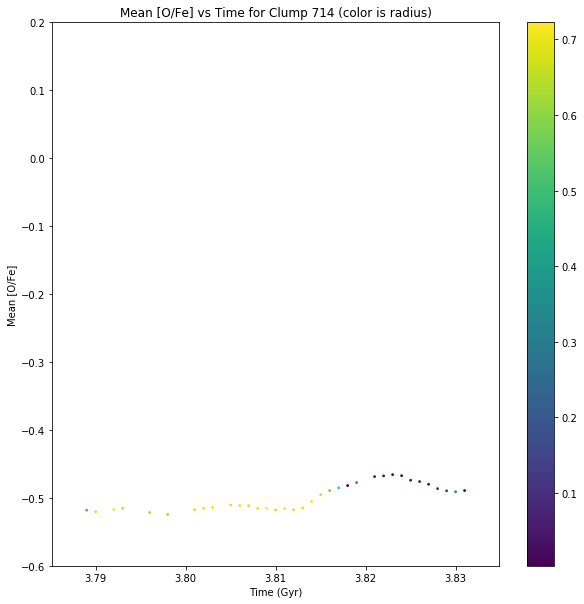

In [17]:
for clumpid in np.unique(np.array(txy['CLUMPID'])):
    plt.figure(figsize=(10,10))
    txyclump = txy[(txy['CLUMPID']==clumpid)]
    plt.scatter(txyclump['TIME'],txyclump['MEANOFE'],c=(txyclump['X']**2+txyclump['Y']**2)**(1/2),s=3)
    plt.colorbar()
    plt.xlabel('Time (Gyr)')
    plt.ylabel('Mean [O/Fe]')
    plt.title('Mean [O/Fe] vs Time for Clump {} (color is radius)'.format(clumpid))
    plt.ylim((-0.6,0.2))

C:\Users\betha\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


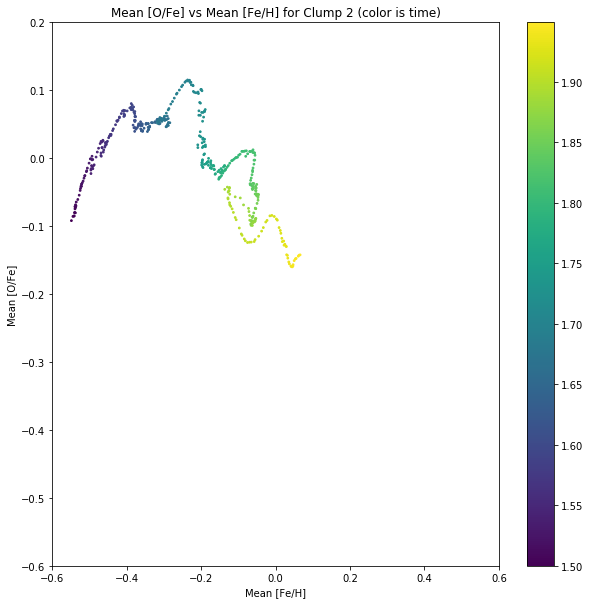

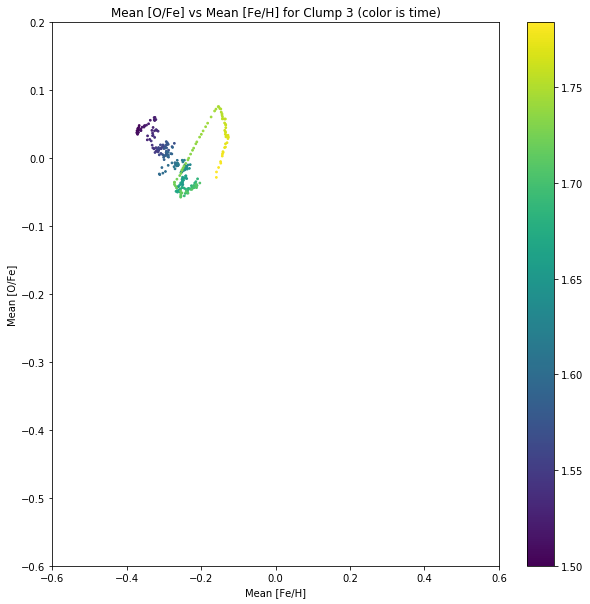

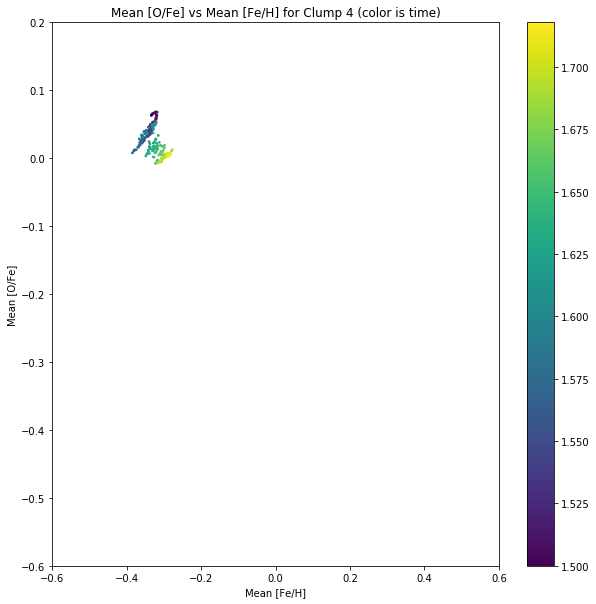

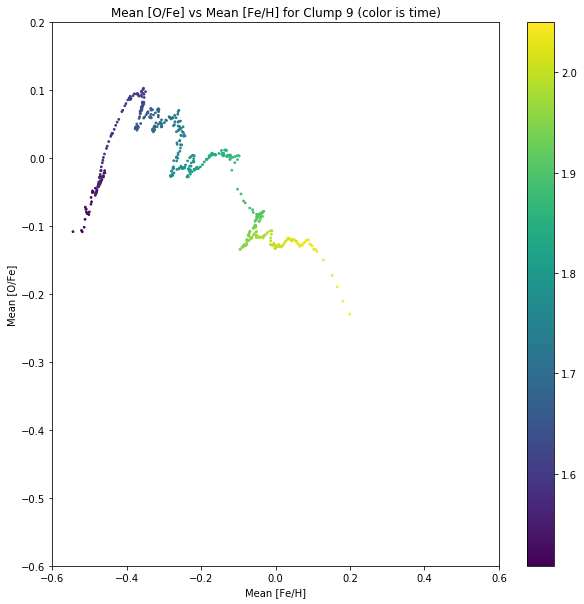

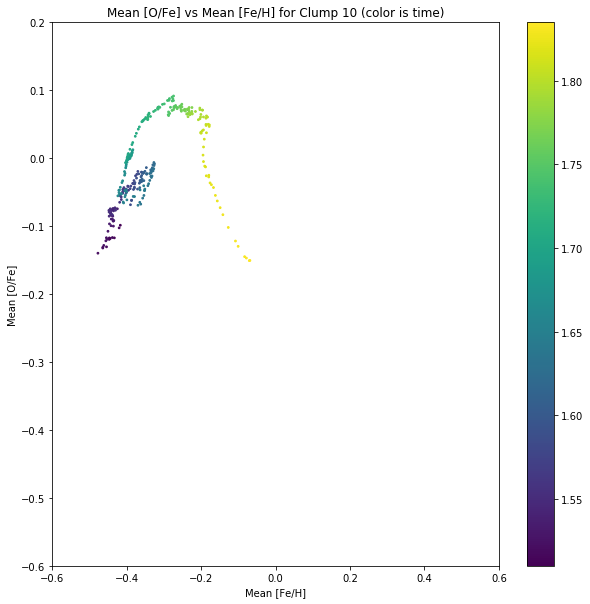

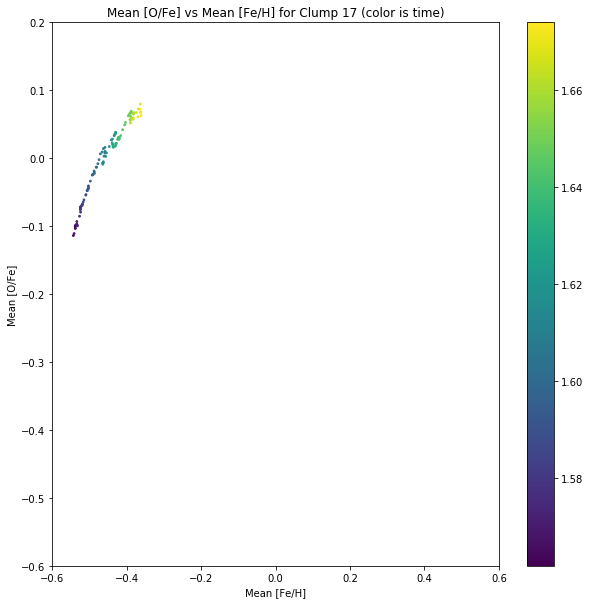

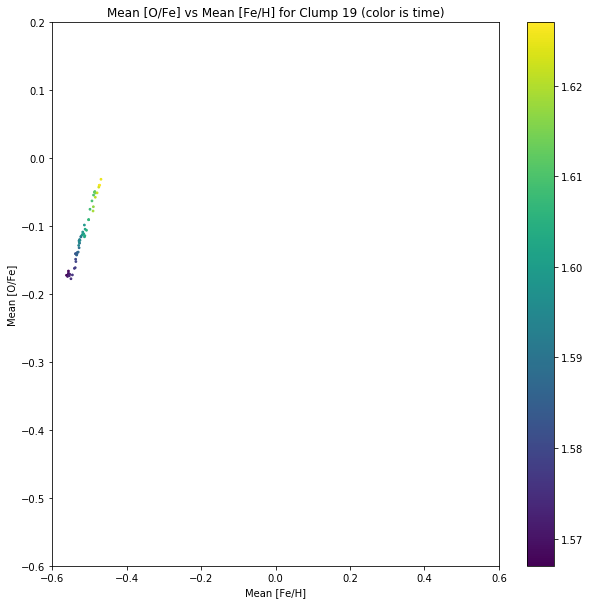

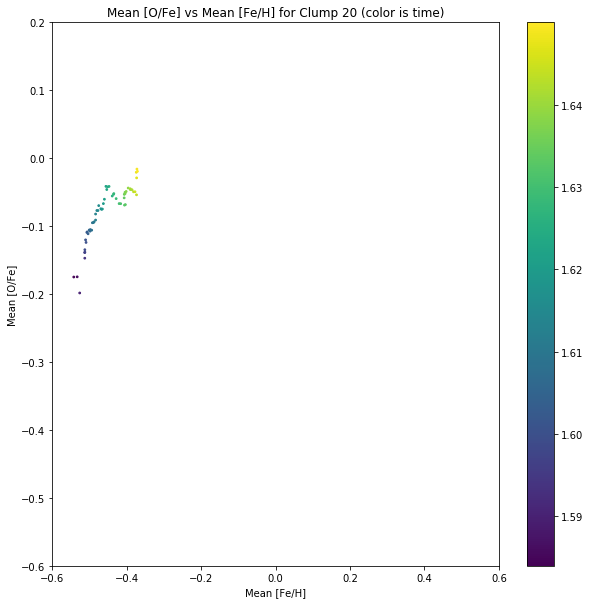

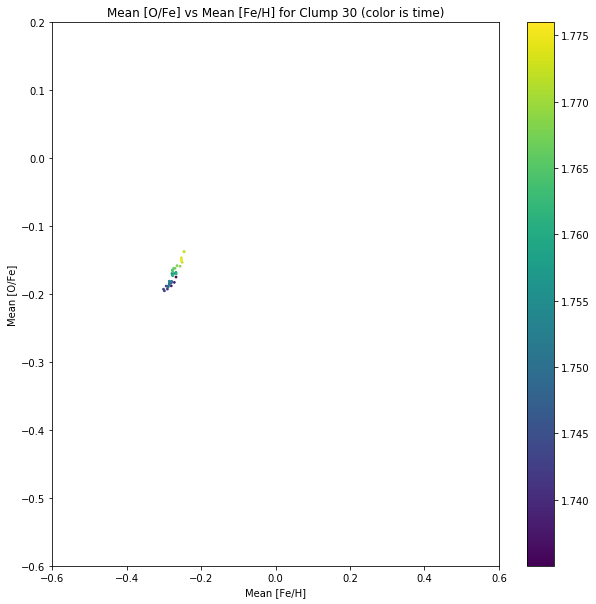

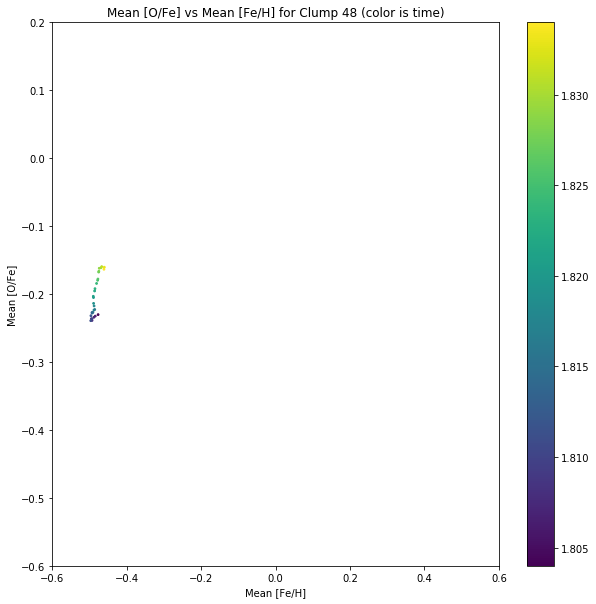

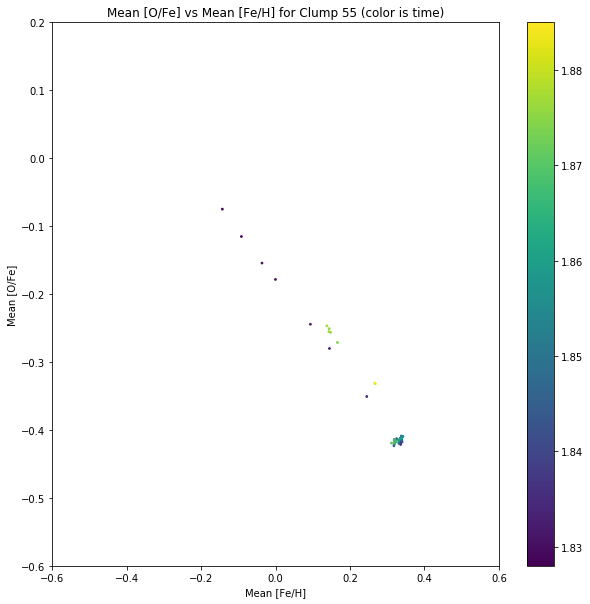

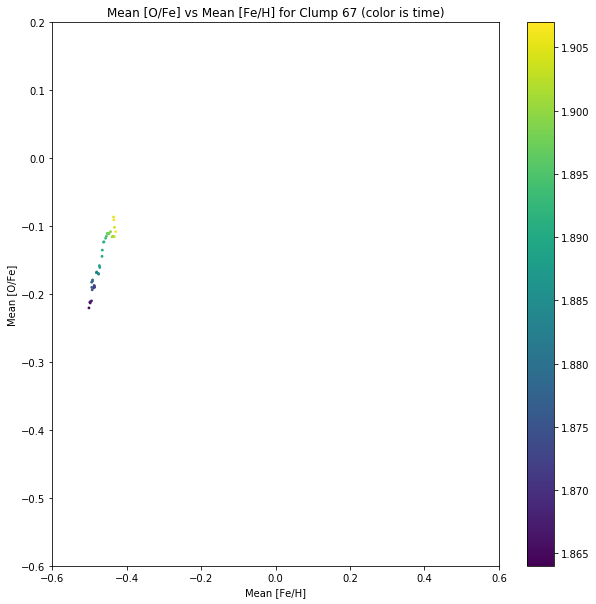

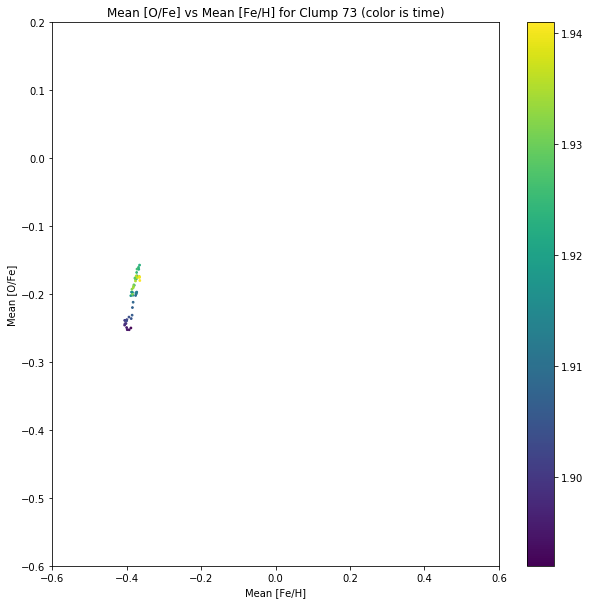

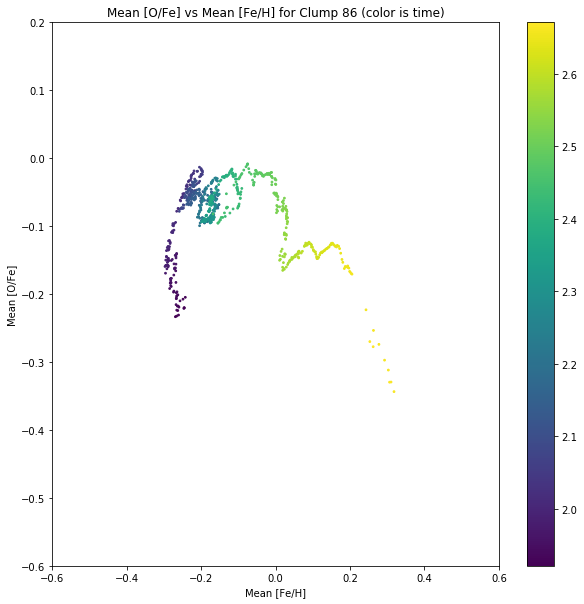

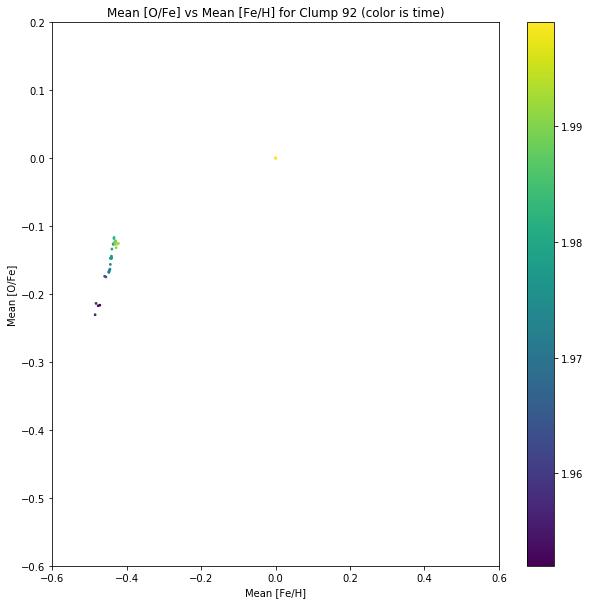

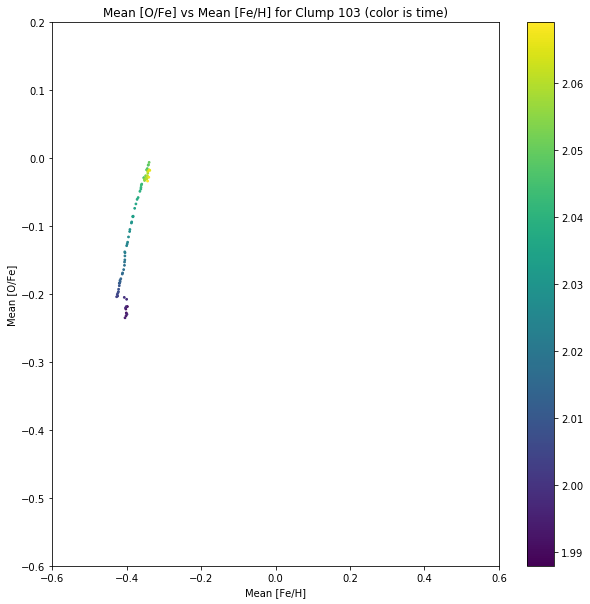

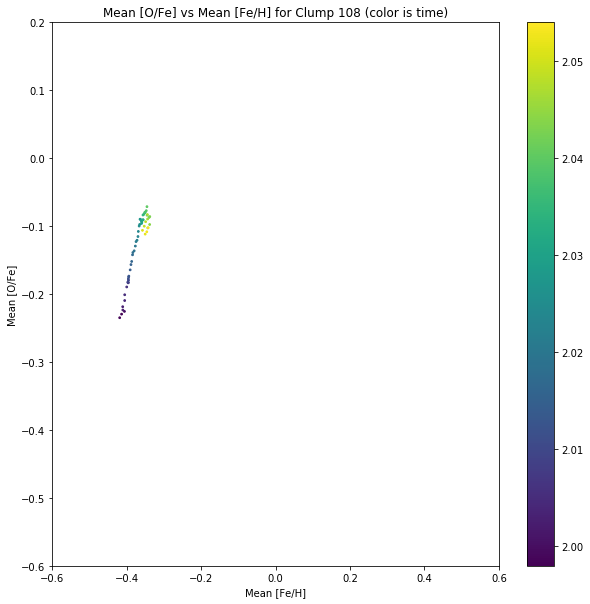

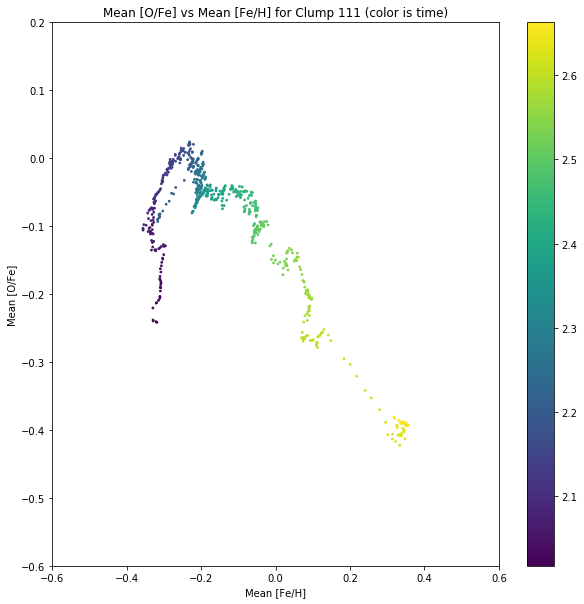

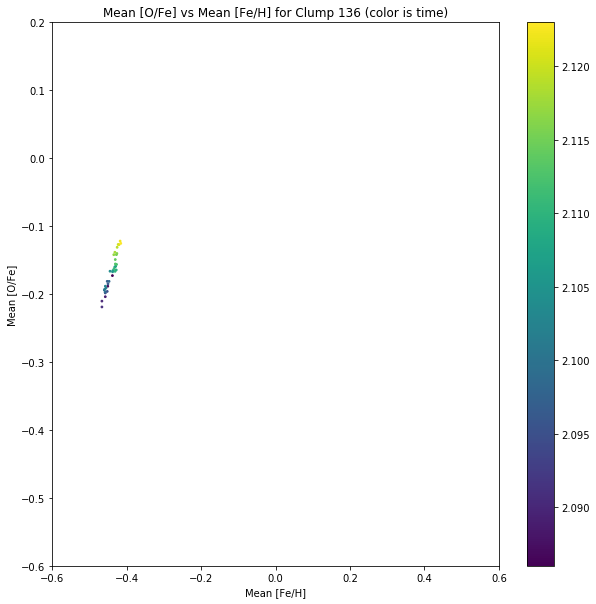

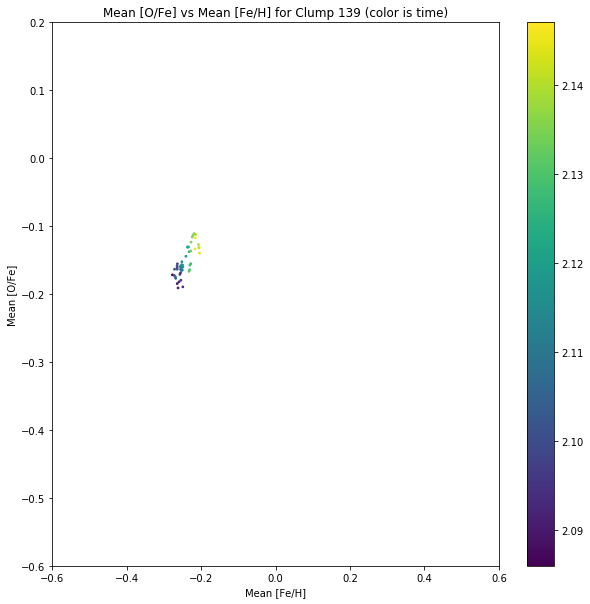

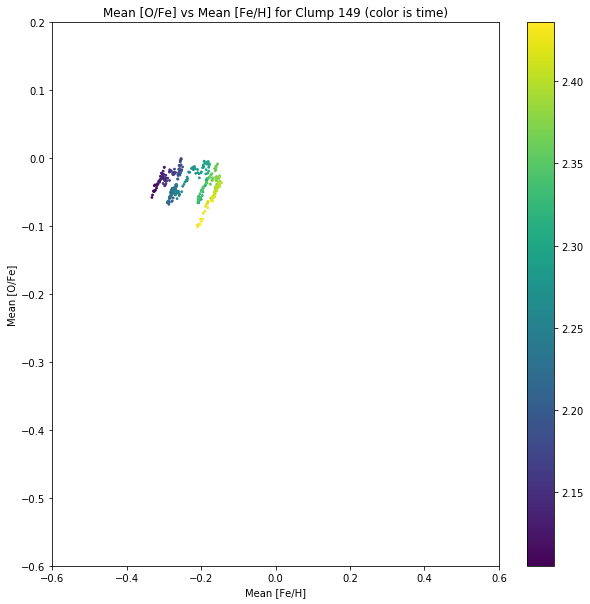

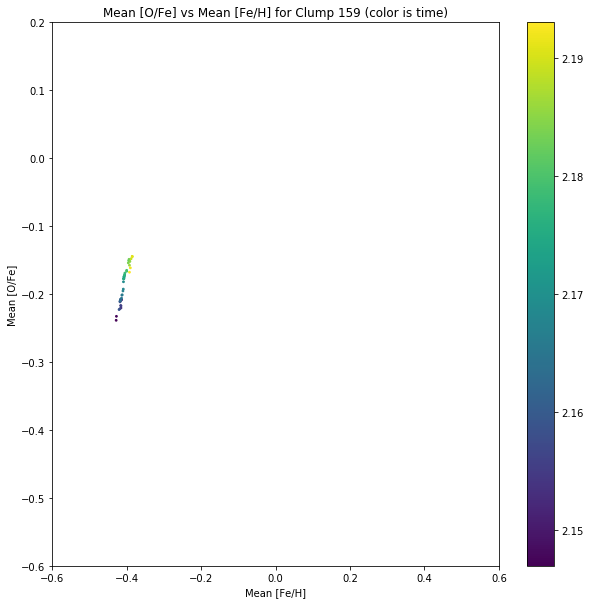

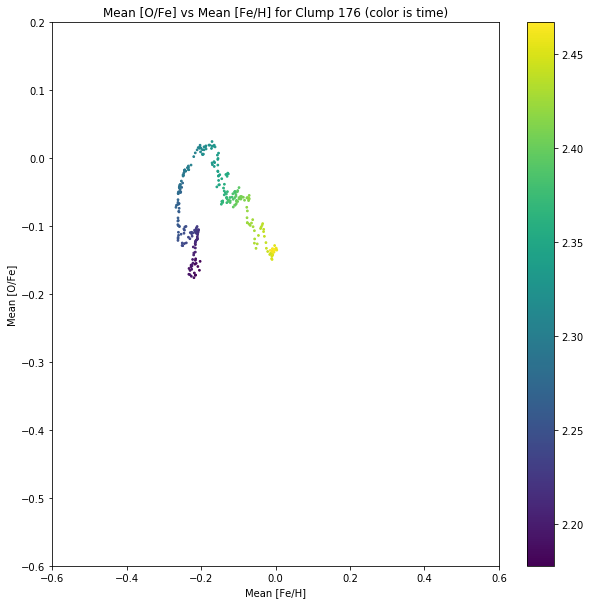

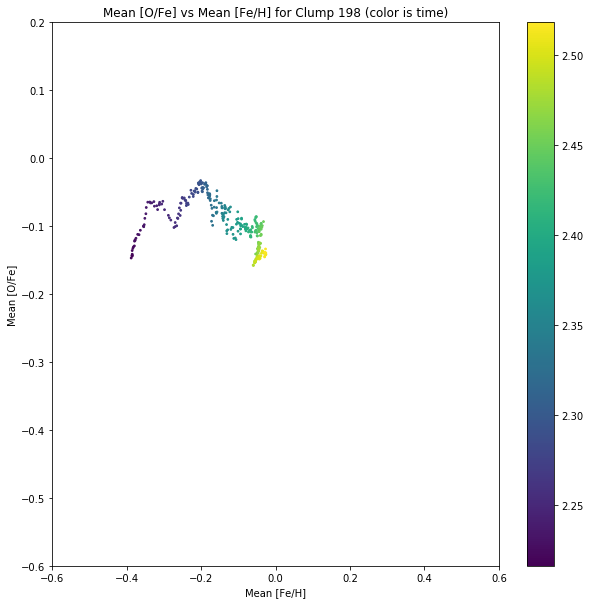

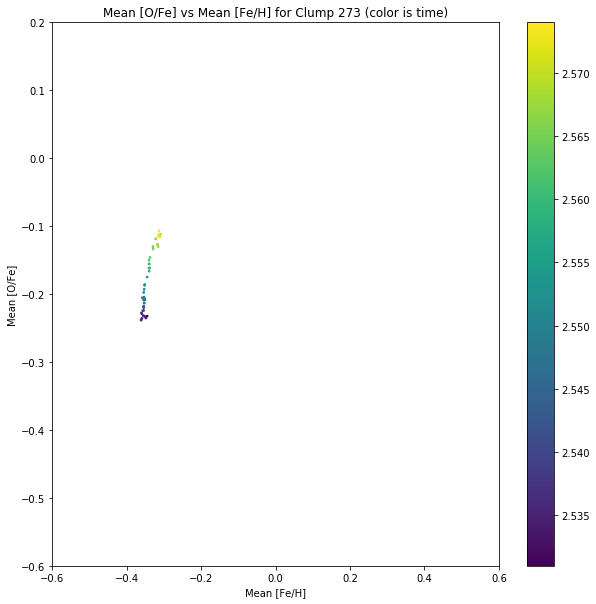

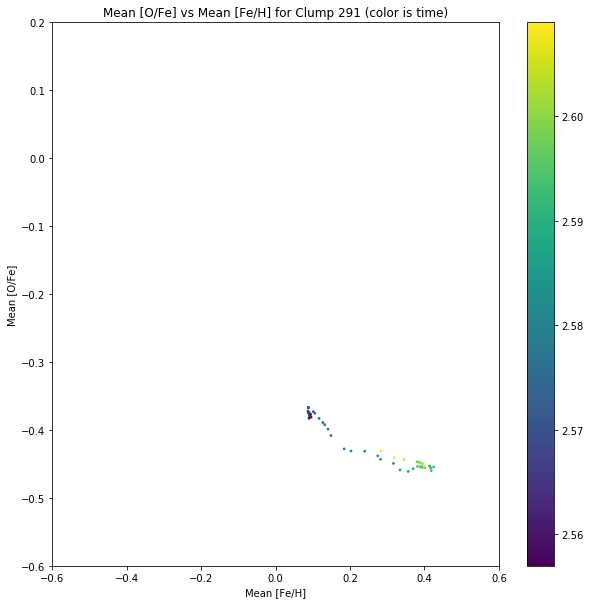

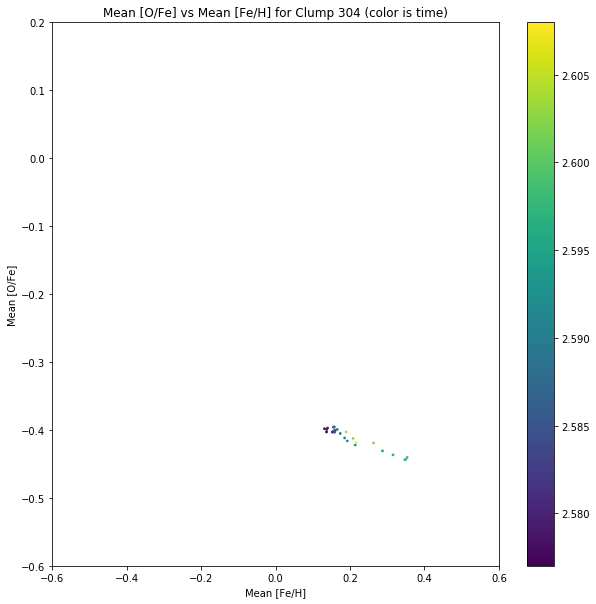

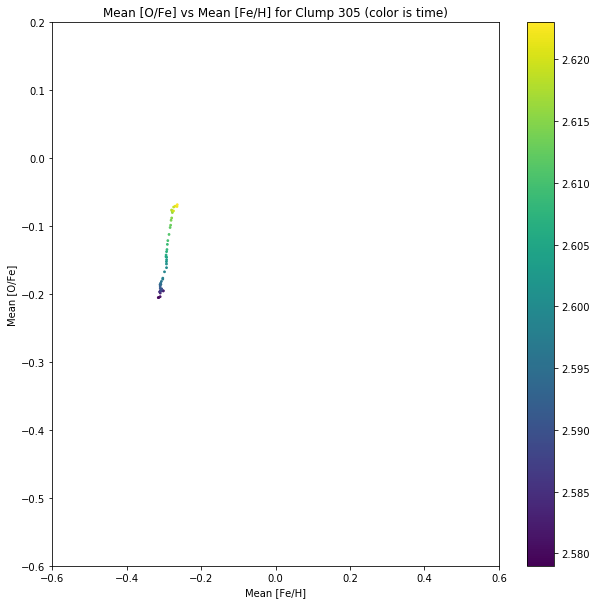

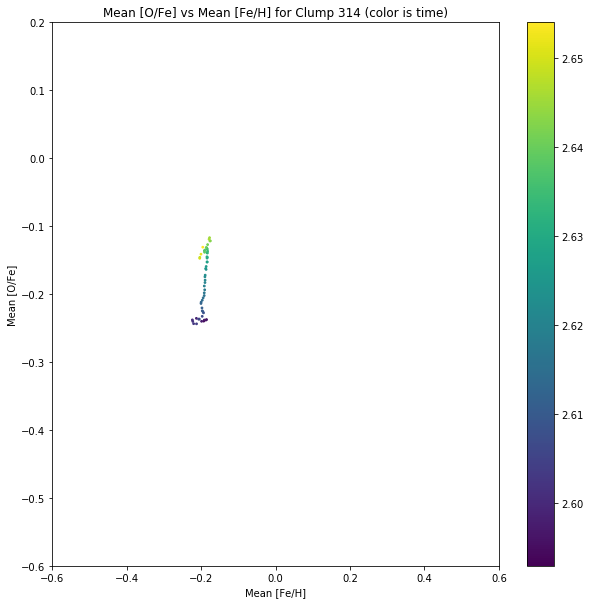

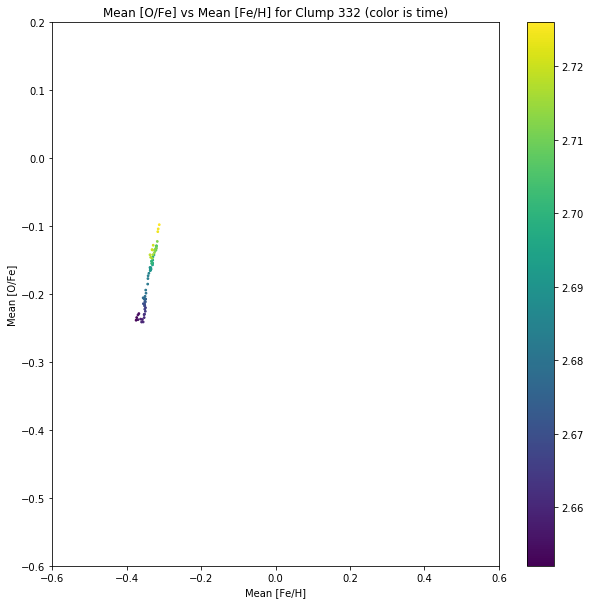

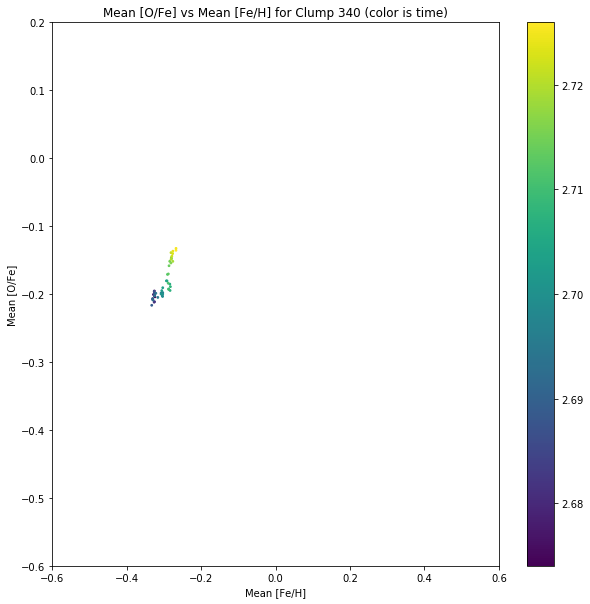

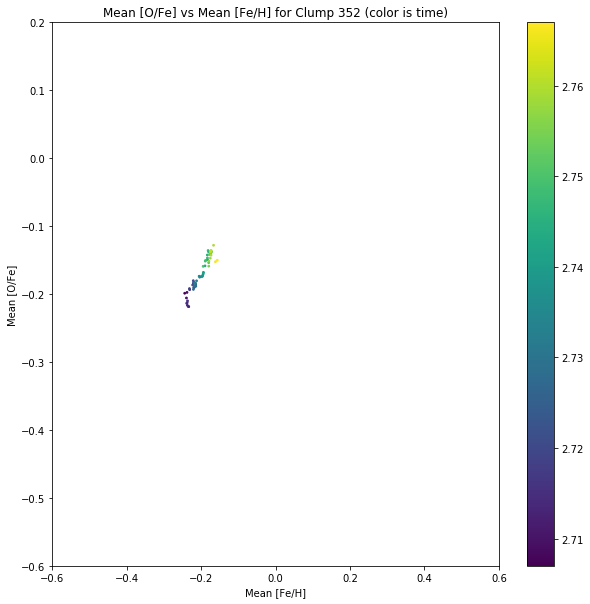

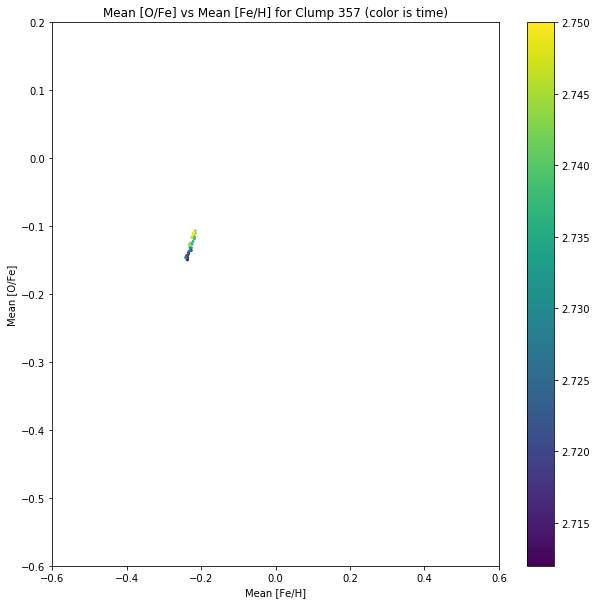

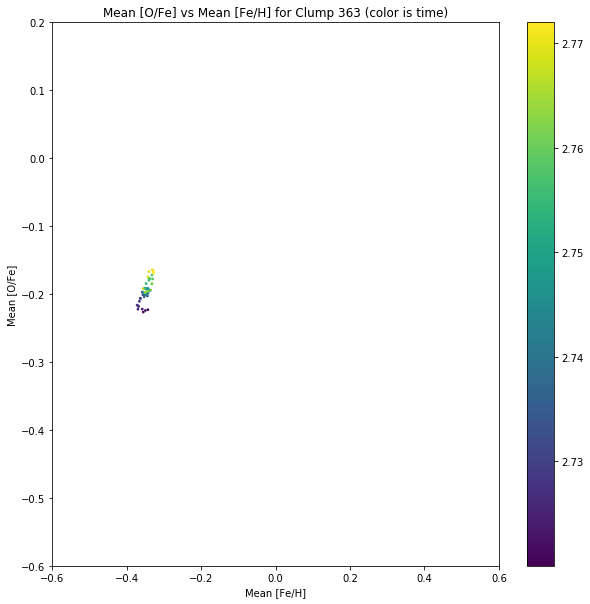

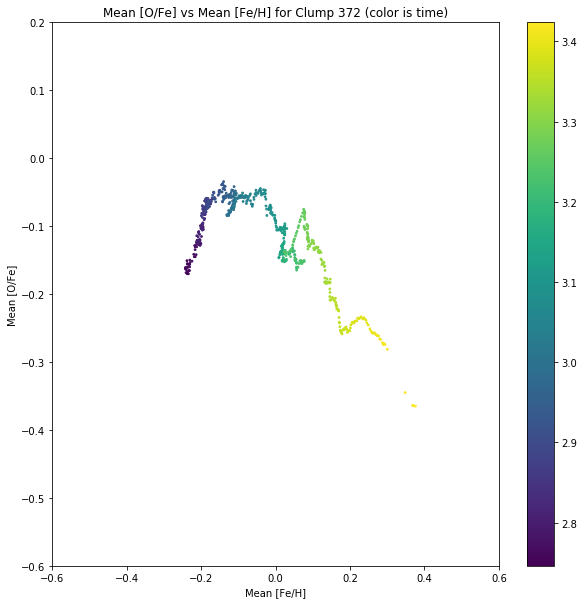

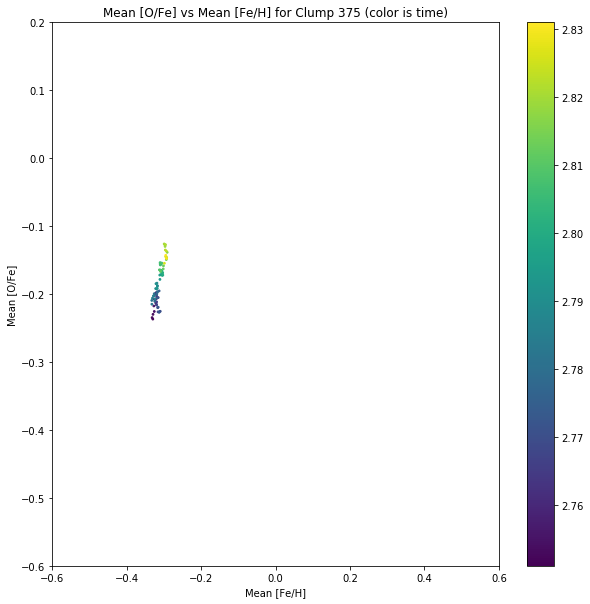

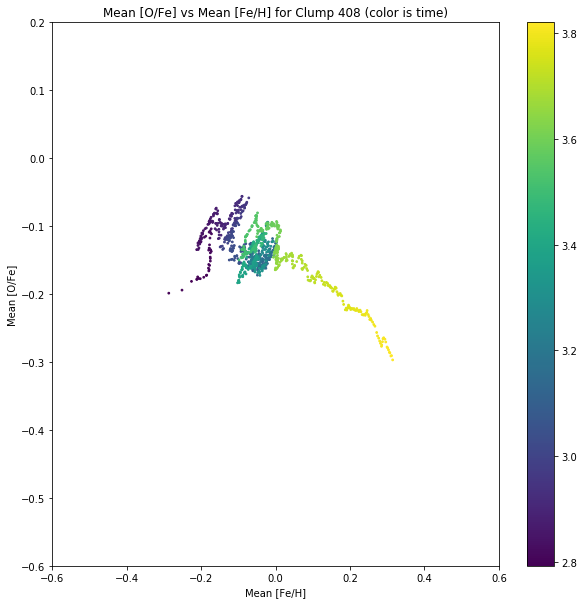

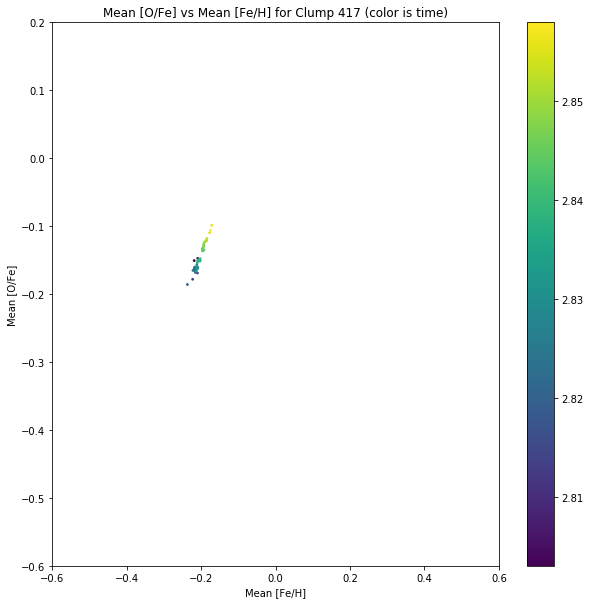

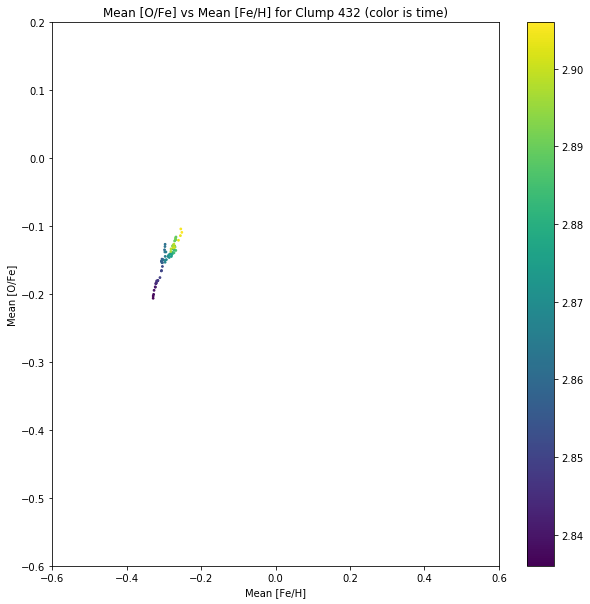

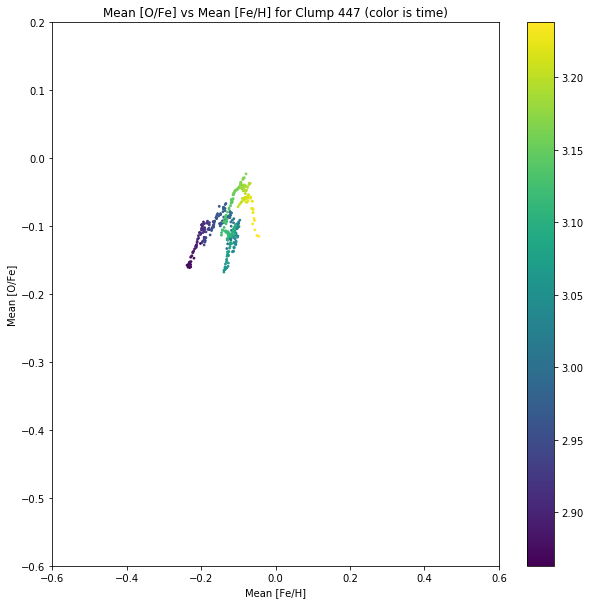

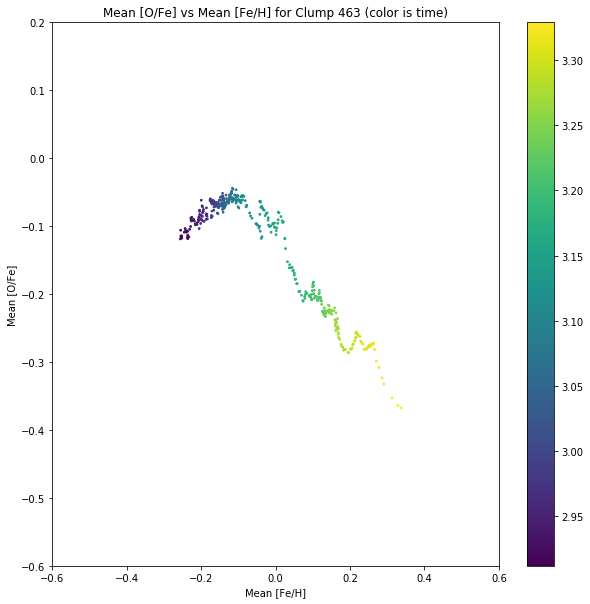

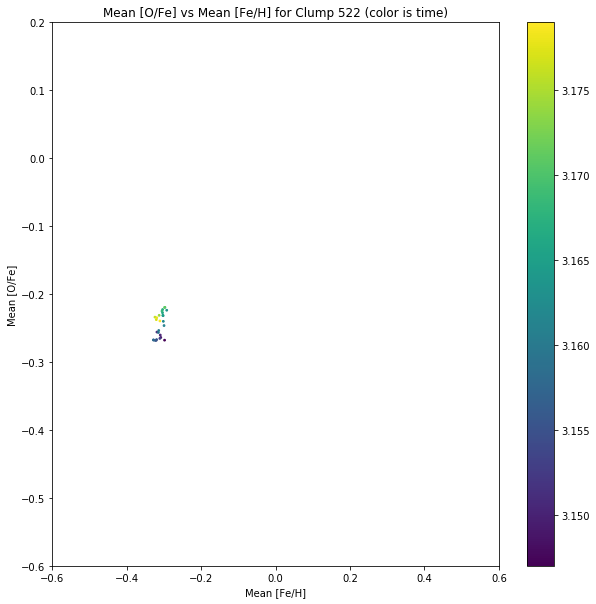

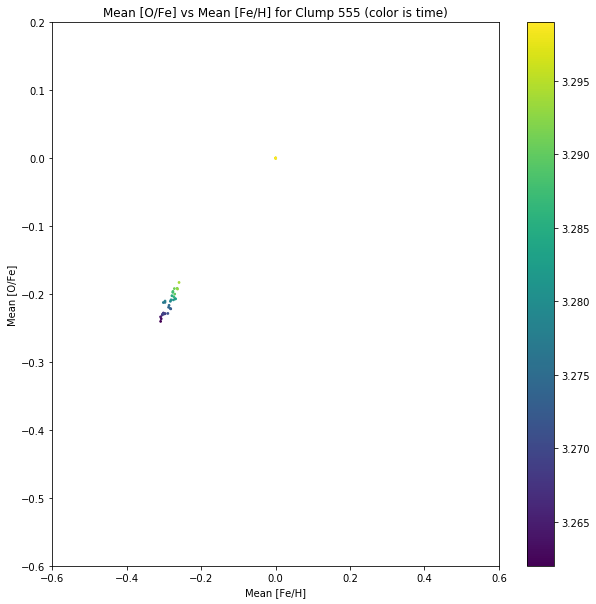

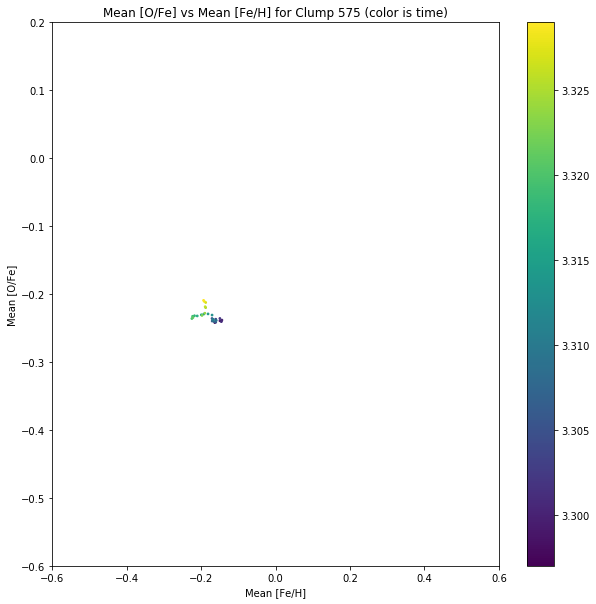

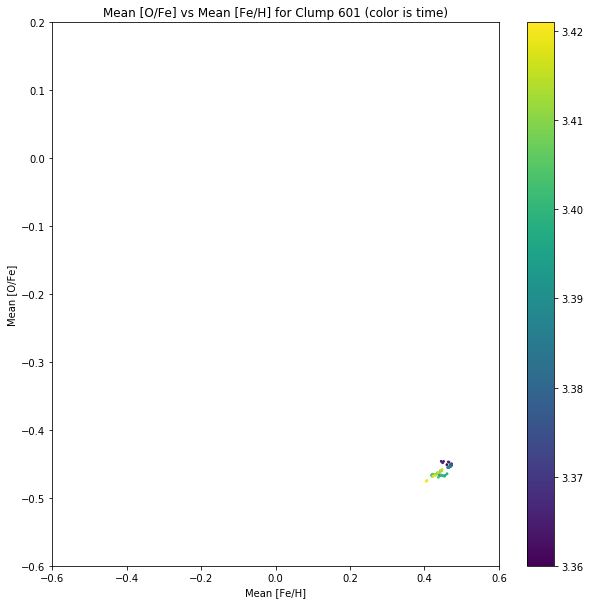

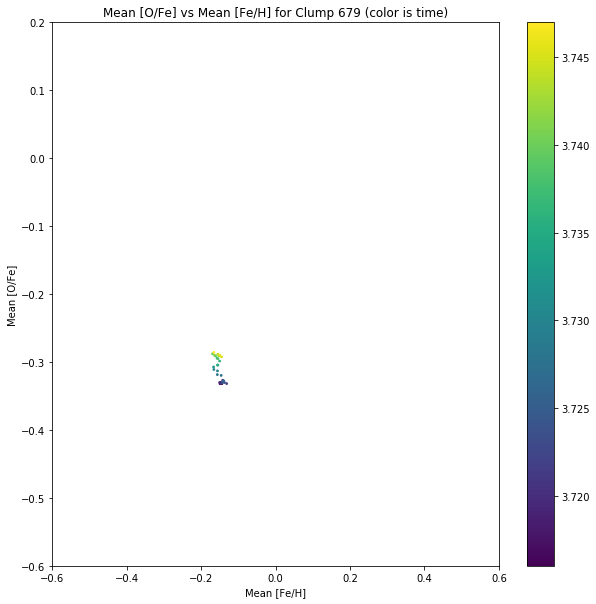

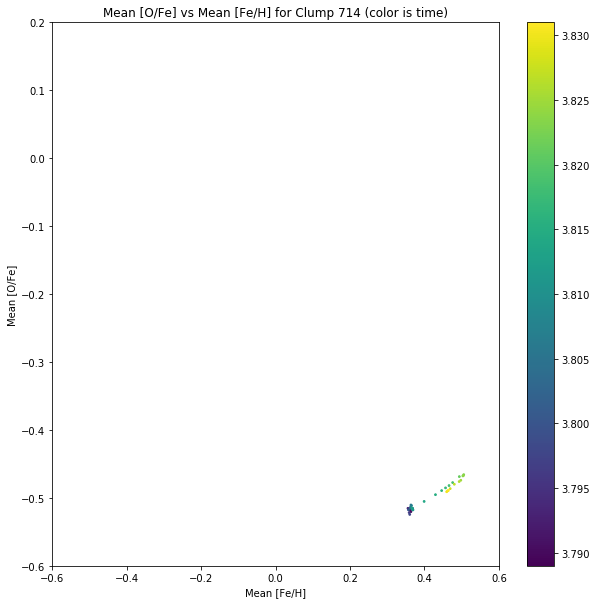

In [18]:
for clumpid in np.unique(np.array(txy['CLUMPID'])):
    plt.figure(figsize=(10,10))
    txyclump = txy[(txy['CLUMPID']==clumpid)]
    plt.scatter(txyclump['MEANFEH'],txyclump['MEANOFE'],c=txyclump['TIME'],s=3)
    plt.colorbar()
    plt.xlabel('Mean [Fe/H]')
    plt.ylabel('Mean [O/Fe]')
    plt.title('Mean [O/Fe] vs Mean [Fe/H] for Clump {} (color is time)'.format(clumpid))
    plt.xlim((-0.6,0.6))
    plt.ylim((-0.6,0.2))

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [O/Fe] vs SFR (color is log mass)')

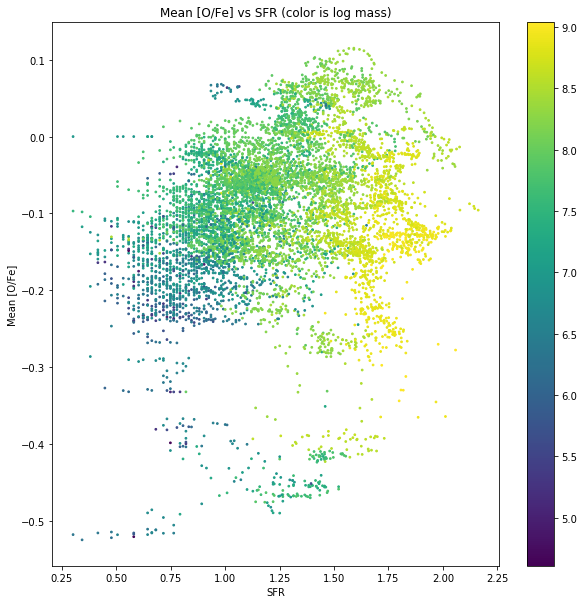

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['NSTARS']/5),txy['MEANOFE'],c=np.log10(txy['MASS']),s=3)
plt.colorbar()
plt.xlabel('SFR')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs SFR (color is log mass)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [Fe/H] vs SFR (color is log mass)')

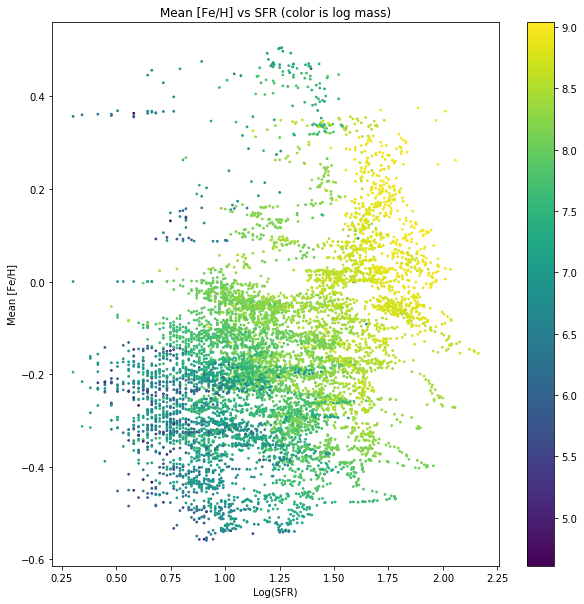

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['NSTARS']/5),txy['MEANFEH'],c=np.log10(txy['MASS']),s=3)
plt.colorbar()
plt.xlabel('Log(SFR)')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs SFR (color is log mass)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


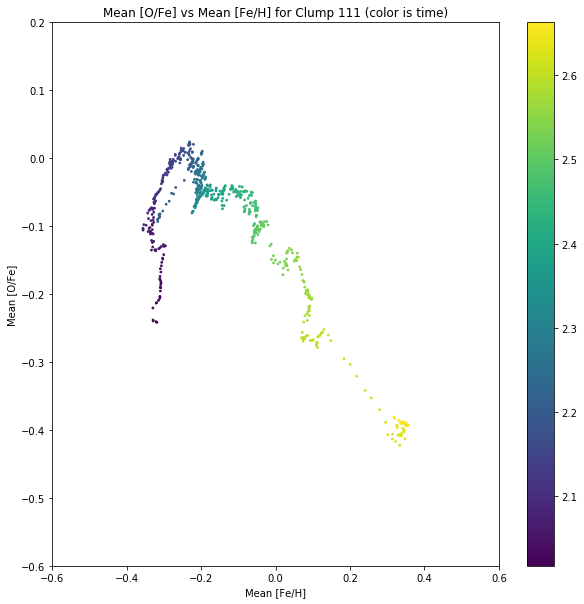

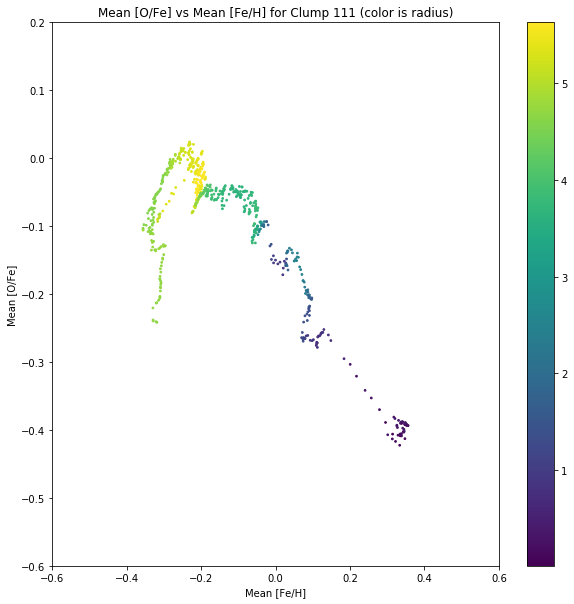

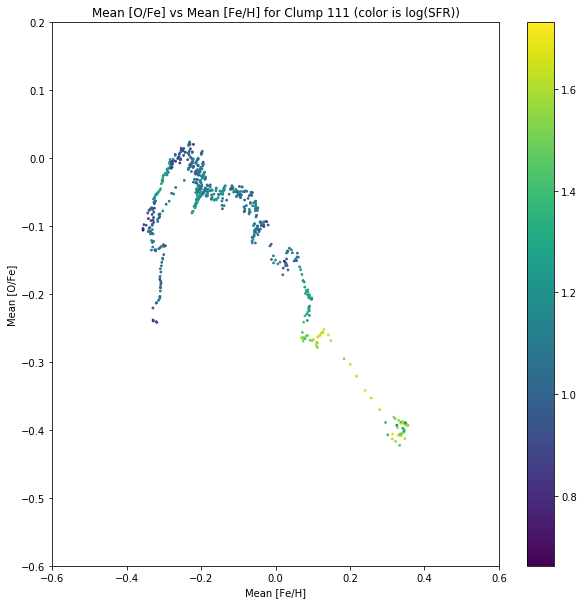

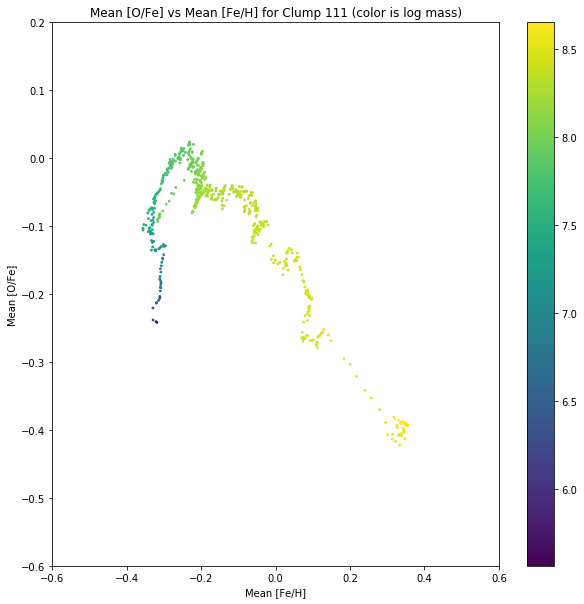

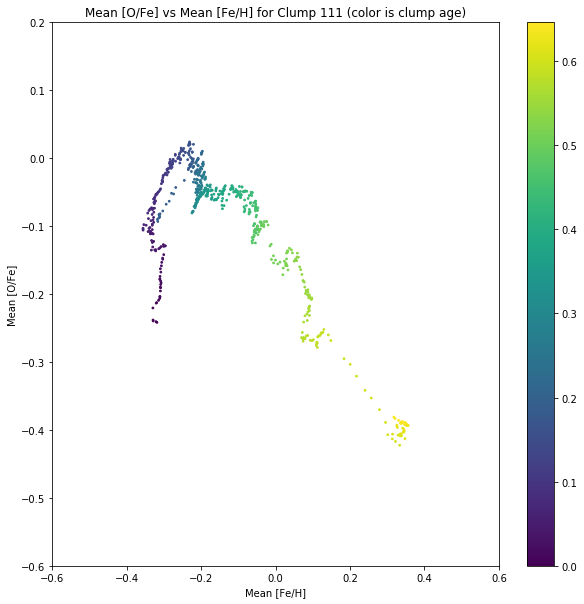

In [21]:
txy111 = txy[(txy['CLUMPID']==111)]
colors = [['time',txy111['TIME']],['radius',(txy111['X']**2+txy111['Y']**2)**(1/2)],
          ['log(SFR)',np.log10(txy111['NSTARS']/5)],['log mass',np.log10(txy111['MASS'])],['clump age',txy111['AGE']]]
for i in colors:
    plt.figure(figsize=(10,10))
    plt.scatter(txy111['MEANFEH'],txy111['MEANOFE'],c=i[1],s=3)
    plt.colorbar()
    plt.xlabel('Mean [Fe/H]')
    plt.ylabel('Mean [O/Fe]')
    plt.title('Mean [O/Fe] vs Mean [Fe/H] for Clump 111 (color is {})'.format(i[0]))
    plt.xlim((-0.6,0.6))
    plt.ylim((-0.6,0.2))

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [Fe/H] vs Log Mass (color is SFR)')

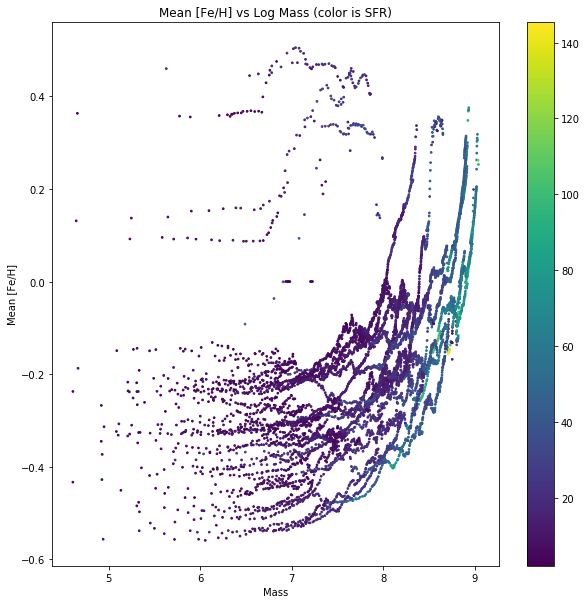

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['MASS']),txy['MEANFEH'],c=txy['NSTARS']/5,s=3)
plt.colorbar()
plt.xlabel('Mass')
plt.ylabel('Mean [Fe/H]')
plt.title('Mean [Fe/H] vs Log Mass (color is SFR)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Mean [O/Fe] vs Log Mass (color is SFR)')

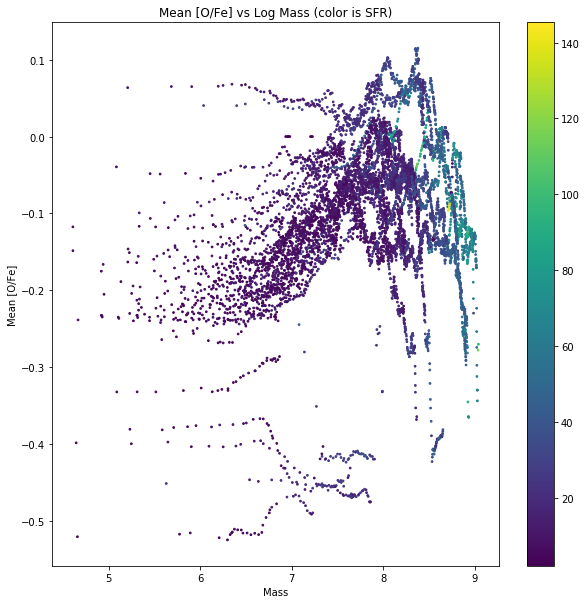

In [23]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['MASS']),txy['MEANOFE'],c=txy['NSTARS']/5,s=3)
plt.colorbar()
plt.xlabel('Mass')
plt.ylabel('Mean [O/Fe]')
plt.title('Mean [O/Fe] vs Log Mass (color is SFR)')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Log SFR vs Log Mass (color is Mean [Fe/H])')

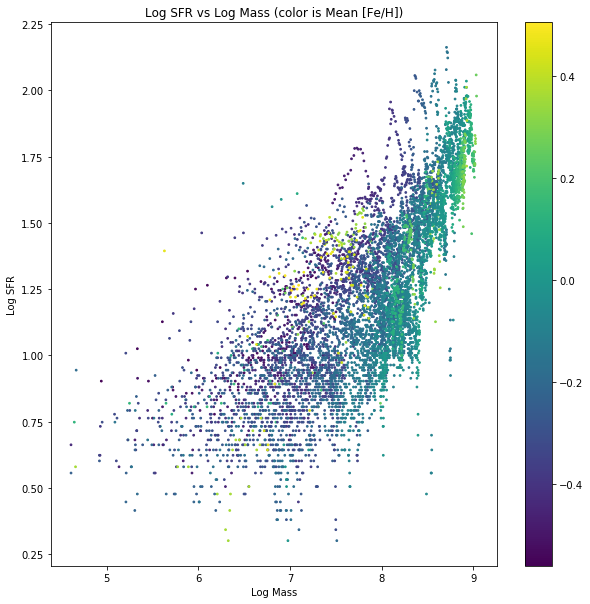

In [39]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['MASS']),np.log10(txy['NSTARS']/5),c=txy['MEANFEH'],s=3)
plt.colorbar()
plt.xlabel('Log Mass')
plt.ylabel('Log SFR')
plt.title('Log SFR vs Log Mass (color is Mean [Fe/H])')

C:\Users\betha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'Log SFR vs Log Mass (color is Mean [O/Fe])')

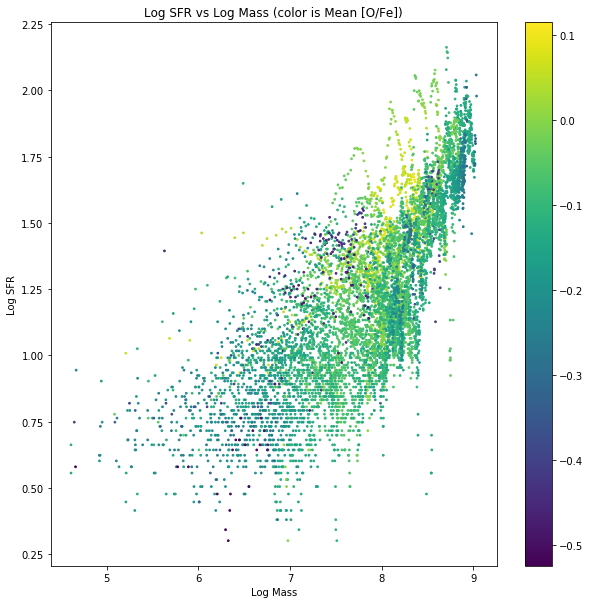

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(txy['MASS']),np.log10(txy['NSTARS']/5),c=txy['MEANOFE'],s=3)
plt.colorbar()
plt.xlabel('Log Mass')
plt.ylabel('Log SFR')
plt.title('Log SFR vs Log Mass (color is Mean [O/Fe])')